# Evaluation of Nanopore-base drug resistance prediction

This notebook contains the figures and tables for the drug resistance prediction component of our paper *Nanopore sequencing for _Mycobacterium tuberculosis_ public health applications*

In [115]:
import pandas as pd
from pathlib import Path
from typing import Tuple
from itertools import product
from collections import defaultdict
import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt
from enum import Enum
from dataclasses import dataclass
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot

phenosheet = "../../../../docs/phenotypes.csv"#snakemake.input.phenosheet
plt.style.use("ggplot")
CONF = 0.95

Load the concordance data. This gives us the mykrobe Illumina and Nanopore calls for each sample-drug combination.

In [116]:
covdf = pd.read_csv("../../coverage.csv", index_col="sample")

In [117]:
concordance_files = [Path(p) for p in Path("../../results/concordance/").rglob("*.csv")]

In [118]:
frames = []
for p in concordance_files:
    sample, tool = p.name.split(".")[0:2]
    tech = p.parts[-3]
    site = p.parts[-2]
    table = pd.read_csv(p)
    table["sample"] = sample
    table["tool"] = tool
    table["tech"] = tech
    table["site"] = site
    frames.append(table)

In [119]:
calls = pd.concat(frames)
calls.reset_index(drop=True, inplace=True)
valid_samples = set(calls["sample"])

In [120]:
calls

,drug,classification,true_call,test_call,sample,tool,tech,site
0,Ofloxacin,TN,S,S,18_0622434,mykrobe,illumina,birmingham
1,Moxifloxacin,TN,S,S,18_0622434,mykrobe,illumina,birmingham
2,Isoniazid,TP,R,R,18_0622434,mykrobe,illumina,birmingham
3,Kanamycin,TN,S,S,18_0622434,mykrobe,illumina,birmingham
4,Ethambutol,TN,S,S,18_0622434,mykrobe,illumina,birmingham
...,...,...,...,...,...,...,...,...
6595,Ciprofloxacin,TN,S,S,mada_1-16,drprg,nanopore,madagascar
6596,Pyrazinamide,TN,S,S,mada_1-16,drprg,nanopore,madagascar
6597,Rifampicin,TP,R,R,mada_1-16,drprg,nanopore,madagascar
6598,Amikacin,TN,S,S,mada_1-16,drprg,nanopore,madagascar


Load the phenotype information

In [121]:
pheno = pd.read_csv(phenosheet).melt(
    id_vars=["sample"], var_name="drug", value_name="phenotype"
)
arr = []
for r in pheno["phenotype"]:
    if pd.isna(r):
        arr.append(r)
    elif r.upper() in ("R", "S"):
        arr.append(r.upper())
    else:
        arr.append(None)
pheno["phenotype"] = arr
pheno = pheno.loc[pheno["sample"].isin(valid_samples)]
pheno.set_index(["sample", "drug"], drop=False, inplace=True)
pheno.sort_index(inplace=True)

In [122]:
pheno

sample               drug phenotype
sample    drug                                                     
R15311    amikacin              R15311           amikacin         S
          amikacin-lpa          R15311       amikacin-lpa       NaN
          capreomycin           R15311        capreomycin       NaN
          capreomycin-lpa       R15311    capreomycin-lpa       NaN
          ciprofloxacin-lpa     R15311  ciprofloxacin-lpa       NaN
...                                ...                ...       ...
mada_2-53 pyrazinamide       mada_2-53       pyrazinamide       NaN
          rifampicin         mada_2-53         rifampicin         R
          rifampicin-lpa     mada_2-53     rifampicin-lpa         S
          streptomycin       mada_2-53       streptomycin         S
          thioacetazone      mada_2-53      thioacetazone         R

[2860 rows x 3 columns]

In [123]:
DRUGS = sorted(set(calls["drug"]))

In [124]:
d = {}
samples_with_pheno = []
for drug in map(str.lower, DRUGS):
    samples = list(pheno.query("drug == @drug").dropna()["sample"])
    samples_with_pheno.extend(samples)
    if samples:
        d[drug.upper()] = samples
#     lpa = drug + "-lpa"
#     samples = list(pheno.query("drug == @lpa").dropna()["sample"])
#     if samples:
#         d[lpa.upper()] = samples

In [125]:
for n in range(1, 10):
    print(n)
    print(len([k for k,g in groupby(sorted(samples_with_pheno)) if len(list(g))>=n]))
    print("-----")

1
128
-----
2
127
-----
3
98
-----
4
91
-----
5
51
-----
6
51
-----
7
51
-----
8
50
-----
9
0
-----


In [126]:
upset_data = upsetplot.from_contents(d)

## Figure 1
Culture-based drug susceptibility data available for samples. Each row is a drug, and the columns represent a set of samples that have phenotype information for those drugs with a filled cell. The top panel shows the number of samples in the set for that combination of drugs. The bar plot in the left panel shows the number of samples with phenotype information for that drug.

In [127]:
tbl = pd.DataFrame([(f"{k.split('-')[0].capitalize()}{''.join(map(str.upper, k.partition('-')[-2:]))}", len(v)) for k, v in sorted(d.items())], columns=["Drug", "Count"])

In [128]:
print(tbl.to_latex(index=False))

\begin{tabular}{lr}
\toprule
        Drug &  Count \\
\midrule
    Amikacin &     88 \\
 Capreomycin &     51 \\
  Ethambutol &     90 \\
   Isoniazid &     98 \\
   Kanamycin &     51 \\
Moxifloxacin &      1 \\
   Ofloxacin &     86 \\
Pyrazinamide &      1 \\
  Rifampicin &     91 \\
Streptomycin &     90 \\
\bottomrule
\end{tabular}



In [129]:
# tbl.to_csv("/Users/michaelhall/Downloads/available-dst.csv", index=False)

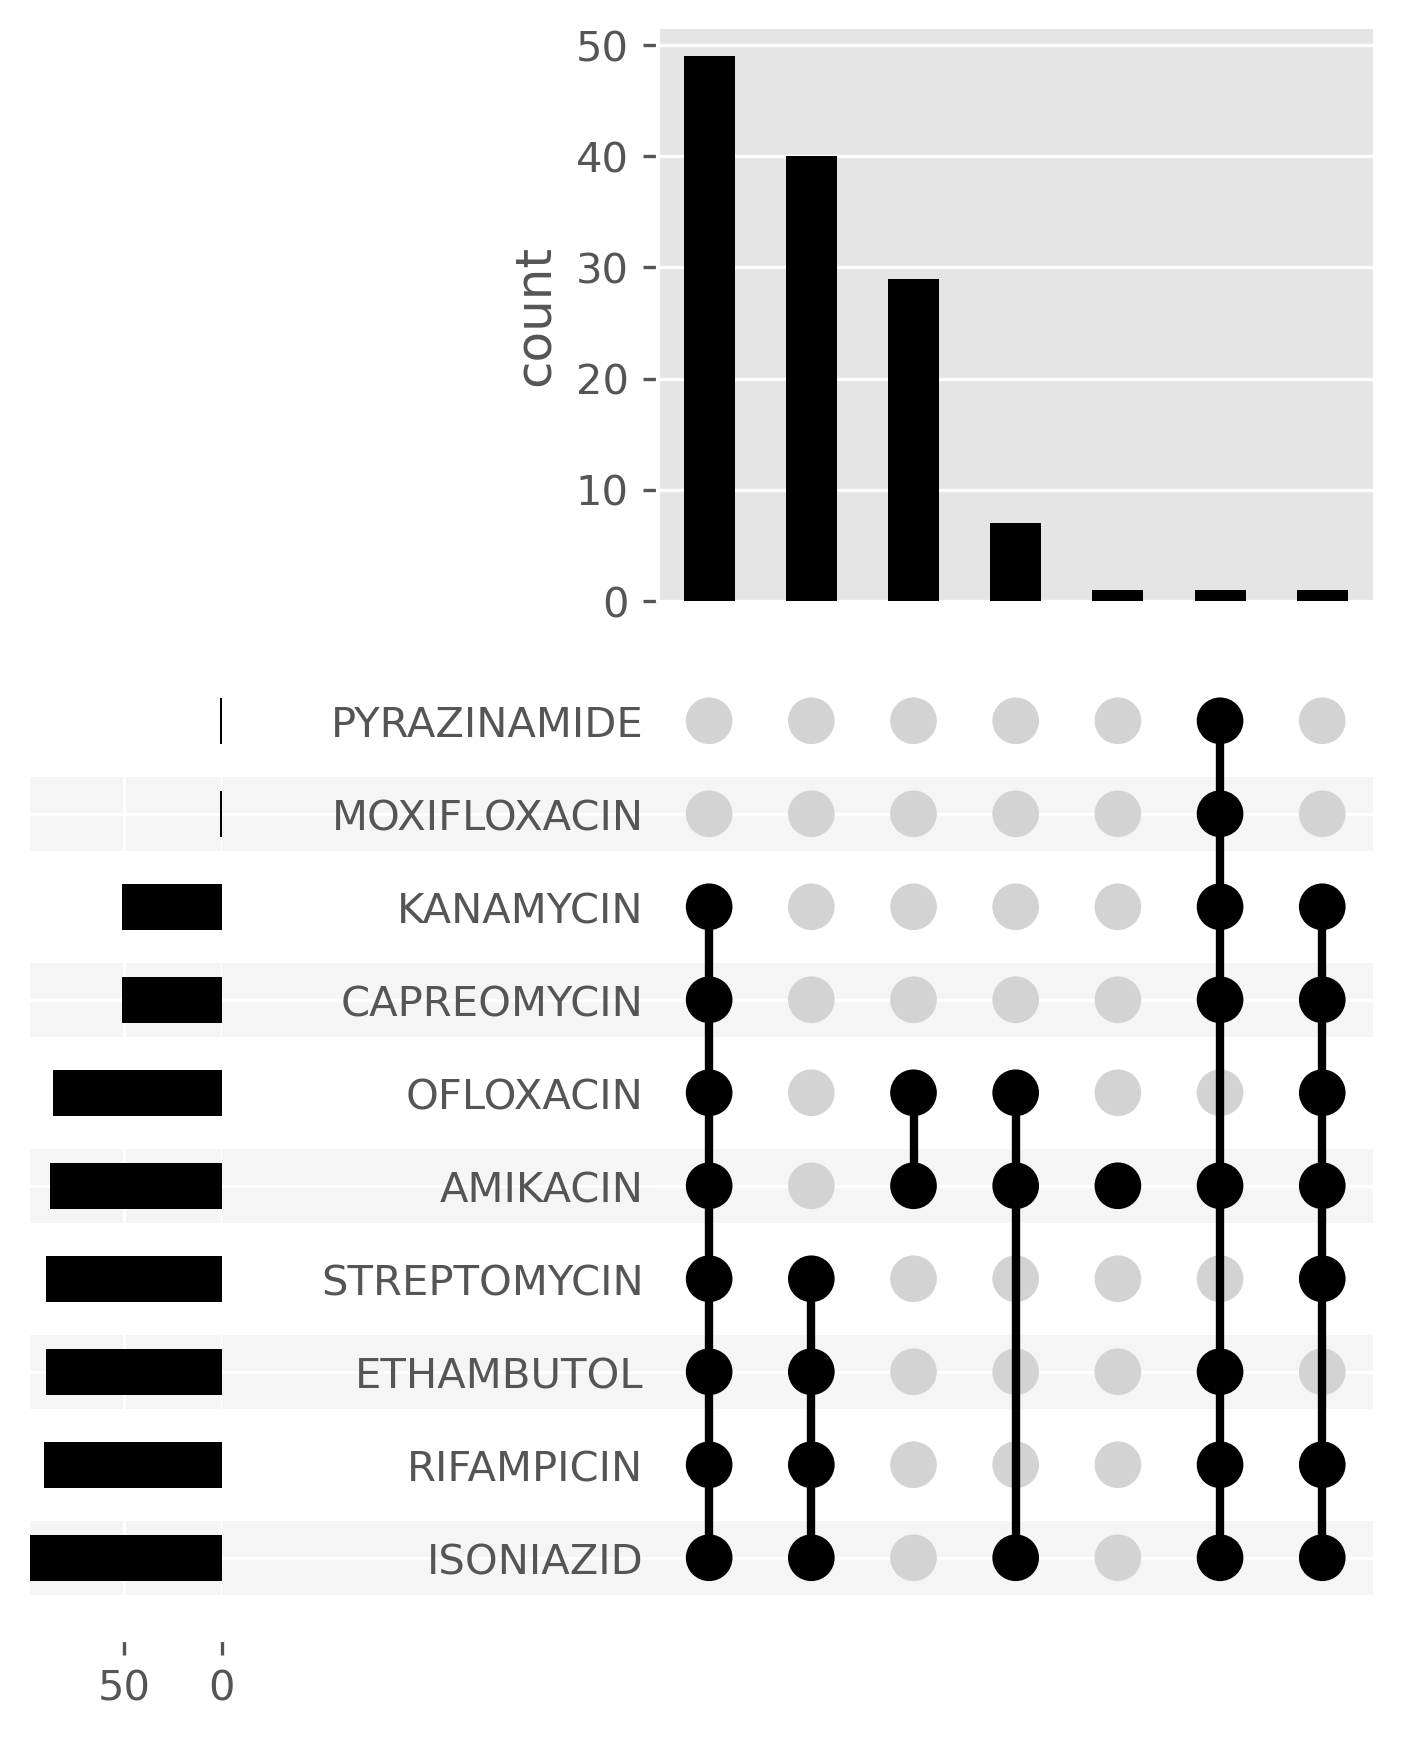

In [130]:
fig, ax = plt.subplots()
p = upsetplot.plot(
    upset_data,
    fig=fig,
    sort_by="cardinality",
    orientation="horizontal",
)
p["intersections"].set_ylabel("count")
ax.axis("off")
# fig.set_figwidth(8)
# fig.set_figheight(10)
fig.set_dpi(300)

In [131]:
# fig.savefig(snakemake.output.dst_data)

## Resistance prediction performance of mykrobe
mykrobe has been rigorously evaluated on datasets which much better/broader phenotype availability. However, it's prediction ability on ONT data has only been validated with 5 samples. We look to validate it's performance on this dataset's Illumina and ONT data, for those drugs/samples where phenotype data is available. 
We will also discuss the causes for any discrepencies and look to COMPASS/bcftools calls for adjudication if possible.

The figure for this section will basically be a copy of [5c/d from the mykrobe nature comms paper](https://www.nature.com/articles/ncomms10063#Fig5) (side-by-side bar charts showing resistant/susceptible samples, with stacked bars indicating FPs and FNs)

In [132]:
# taken from https://apps.who.int/iris/bitstream/handle/10665/130918/9789241548809_eng.pdf?sequence=1&isAllowed=y
drug_abbrev = {
    "ethambutol": "E",
    "isoniazid": "H",
    "pyrazinamide": "Z",
    "rifampicin": "R",
    "streptomycin": "S",
    "kanamycin": "Km",
    "amikacin": "Am",
    "ofloxacin": "Ofx",
    "capreomycin": "Cm",
    "moxifloxacin": "Mfx",
    "ciprofloxacin": "Cfx",
}
ignore_drugs = {"pyrazinamide", "moxifloxacin"}


class Prediction(Enum):
    Resistant = "R"
    Susceptible = "S"
    MinorResistance = "r"
    Unknown = "U"
    Failed = "F"

    def __str__(self) -> str:
        return self.value


class Classification(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value


class Classifier:
    def __init__(
        self,
        minor_is_susceptible: bool = False,
        unknown_is_resistant: bool = False,
        failed_is_resistant: bool = False,
    ):
        self.minor_is_susceptible = minor_is_susceptible
        self.unknown_is_resistant = unknown_is_resistant
        self.failed_is_resistant = failed_is_resistant
        self.susceptible = {Prediction.Susceptible}
        self.resistant = {Prediction.Resistant}
        if self.minor_is_susceptible:
            self.susceptible.add(Prediction.MinorResistance)
        else:
            self.resistant.add(Prediction.MinorResistance)

        if self.unknown_is_resistant:
            self.resistant.add(Prediction.Unknown)
        else:
            self.susceptible.add(Prediction.Unknown)

        if self.failed_is_resistant:
            self.resistant.add(Prediction.Failed)
        else:
            self.susceptible.add(Prediction.Failed)

    def from_predictions(
        self, y_true: Prediction, y_pred: Prediction
    ) -> Classification:
        if y_true in self.susceptible:
            expected_susceptible = True
        elif y_true in self.resistant:
            expected_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_true} calls yet")

        if y_pred in self.susceptible:
            called_susceptible = True
        elif y_pred in self.resistant:
            called_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_pred} calls yet")

        if expected_susceptible and called_susceptible:
            return Classification.TrueNegative
        elif expected_susceptible and not called_susceptible:
            return Classification.FalsePositive
        elif not expected_susceptible and not called_susceptible:
            return Classification.TruePositive
        else:
            return Classification.FalseNegative



@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> Tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def num_positive(self) -> int:
        """Number of TPs and FNs - i.e. actual condition positive"""
        return self.tp + self.fn

    def num_negative(self) -> int:
        """Number of TNs and FPs - i.e. actual condition negative"""
        return self.tn + self.fp

    def ppv(self) -> Tuple[float, float, float]:
        """Also known as precision"""
        try:
            ppv = self.tp / (self.tp + self.fp)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tp, n_f=self.fp)
            return ppv, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def npv(self) -> Tuple[float, float, float]:
        """Negative predictive value"""
        try:
            npv = self.tn / (self.tn + self.fn)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tn, n_f=self.fn)
            return npv, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def sensitivity(self) -> float:
        """Also known as recall and true positive rate (TPR)"""
        try:
            return self.tp / self.num_positive()
        except ZeroDivisionError:
            return None

    def specificity(self) -> float:
        """Also known as selectivity and true negative rate (TNR)"""
        try:
            return self.tn / self.num_negative()
        except ZeroDivisionError:
            return None

    def fnr(self) -> Tuple[float, float, float]:
        """False negative rate or VME (very major error rate)"""
        try:
            fnr = self.fn / self.num_positive()
            lwr_bound, upr_bound = confidence_interval(n_s=self.fn, n_f=self.tp)
            return fnr, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def fpr(self) -> Tuple[float, float, float]:
        """False positive rate or ME (major error rate)"""
        try:
            fpr = self.fp / self.num_negative()
            lwr_bound, upr_bound = confidence_interval(n_s=self.fp, n_f=self.tn)
            return fpr, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def f_score(self, beta: float = 1.0) -> float:
        """Harmonic mean of precision and recall.
        When beta is set to 0, you get precision. When beta is set to 1, you get the
        unweighted F-score which is the harmonic mean of precision and recall. Setting
        beta to 2 weighs recall twice as much as precision. Setting beta to 0.5 weighs
        precision twice as much as recall.
        """
        ppv = self.precision()
        tpr = self.recall()
        if ppv is None or tpr is None:
            return None
        beta2 = beta ** 2

        return ((beta2 + 1) * ppv * tpr) / ((beta2 * ppv) + tpr)

    @staticmethod
    def from_series(s: pd.Series) -> "ConfusionMatrix":
        tp = s.get("TP", 0)
        fp = s.get("FP", 0)
        fn = s.get("FN", 0)
        tn = s.get("TN", 0)
        return ConfusionMatrix(tp=tp, fn=fn, fp=fp, tn=tn)


def confidence_interval(n_s: int, n_f: int, conf: float = CONF) -> Tuple[float, float]:
    """Calculate the Wilson score interval.
    Equation take from https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
    n_s: Number of successes or, in the case of confusion matrix statistics, the numerator
    n_f: Number of failures or, in the case of confusion matrix statistics, the denominator minus the numerator
    conf: the confidence level. i.e. 0.95 is 95% confidence
    """
    n = n_f + n_s
    z = stats.norm.ppf(1 - (1 - conf) / 2)  # two-sided
    z2 = z ** 2
    nz2 = n + z2
    A = (n_s + (0.5 * z2)) / nz2
    B = z / nz2
    C = sqrt(((n_s * n_f) / n) + (z2 / 4))
    CI = B * C
    return A - CI, A + CI


def round_up_to_base(x, base=10):
    return int(x + (base - x) % base)


def round_down_to_base(x, base=10):
    return int(x - (x % base))

In [133]:
pheno_clf = []
minor_is_susceptible = False
unknown_is_resistant = False
failed_is_resistant = False
classifier = Classifier(unknown_is_resistant=unknown_is_resistant, minor_is_susceptible=minor_is_susceptible)

for ix, row in calls.iterrows():
    drug = row["drug"].lower()
    if drug in ignore_drugs:
        continue

    sample = row["sample"]
    try:
        ph = pheno.loc[(sample, drug), "phenotype"]
        if pd.isna(ph).all():
            continue
        else:
            truth = Prediction(ph[0])
    except KeyError:
        continue
    
    tech = row["tech"]
    if tech == "illumina":
        covg = covdf.loc[sample]["illumina_covg"]
    else:
        covg = covdf.loc[sample]["nanopore_covg"]
    
    pred = Prediction(row["test_call"])    
    clf = classifier.from_predictions(truth, pred)

    pheno_clf.append((sample, drug, str(clf), tech, covg, row["tool"], row["site"]))

In [134]:
clf_df = pd.DataFrame(
    pheno_clf, columns=["sample", "drug", "classification", "technology", "coverage", "tool", "site"]
)

In [135]:
pheno_cms = defaultdict()
TOOLS = ["drprg", "mykrobe"]
TECHS = ["nanopore", "illumina"]
PHENO_DRUGS = set()

for drug, tech, tool in product(set(clf_df["drug"]), TECHS, TOOLS):
    s = clf_df.query("drug == @drug and technology == @tech and tool == @tool").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    pheno_cms[(drug, tech, tool)] = cm
    PHENO_DRUGS.add(drug)
    
PHENO_DRUGS = sorted(PHENO_DRUGS)

In [136]:
metrics = []
for (drug, tech, tool), cm in pheno_cms.items():
        #         sensitivity = cm.sensitivity()
        #         specificity = cm.specificity()
    ppv = cm.ppv()[0]
    npv = cm.npv()[0]
    vme = cm.fnr()[0]
    me = cm.fpr()[0]
    metrics.append((drug, tech, tool, ppv, npv, vme, me))

summary_cols = [
    "drug",
    "tech",
    "tool",
    "PPV",
    "NPV",
    "FNR",
    "FPR",
]

summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug", "tech", "tool"], var_name="metric")

## Figure 2
Number of resistant (left) and susceptible (right) phenotypes correctly identified by mykrobe from Illumina (blue) and Nanopore (purple) data from the same samples. The red bars indicate missed (FN) or incorrect (FP) predictions. The x-axis shows the drugs with available phenotype data that mykrobe also makes predictions for. E - ethambutol; H - isoniazid; Z - pyrazinamide; R - rifampicin; S - streptomycin; Km - kanamycin; Am - amikacin; Ofx - ofloxacin; Cm - capreomycin; Mfx - moxifloxacin.

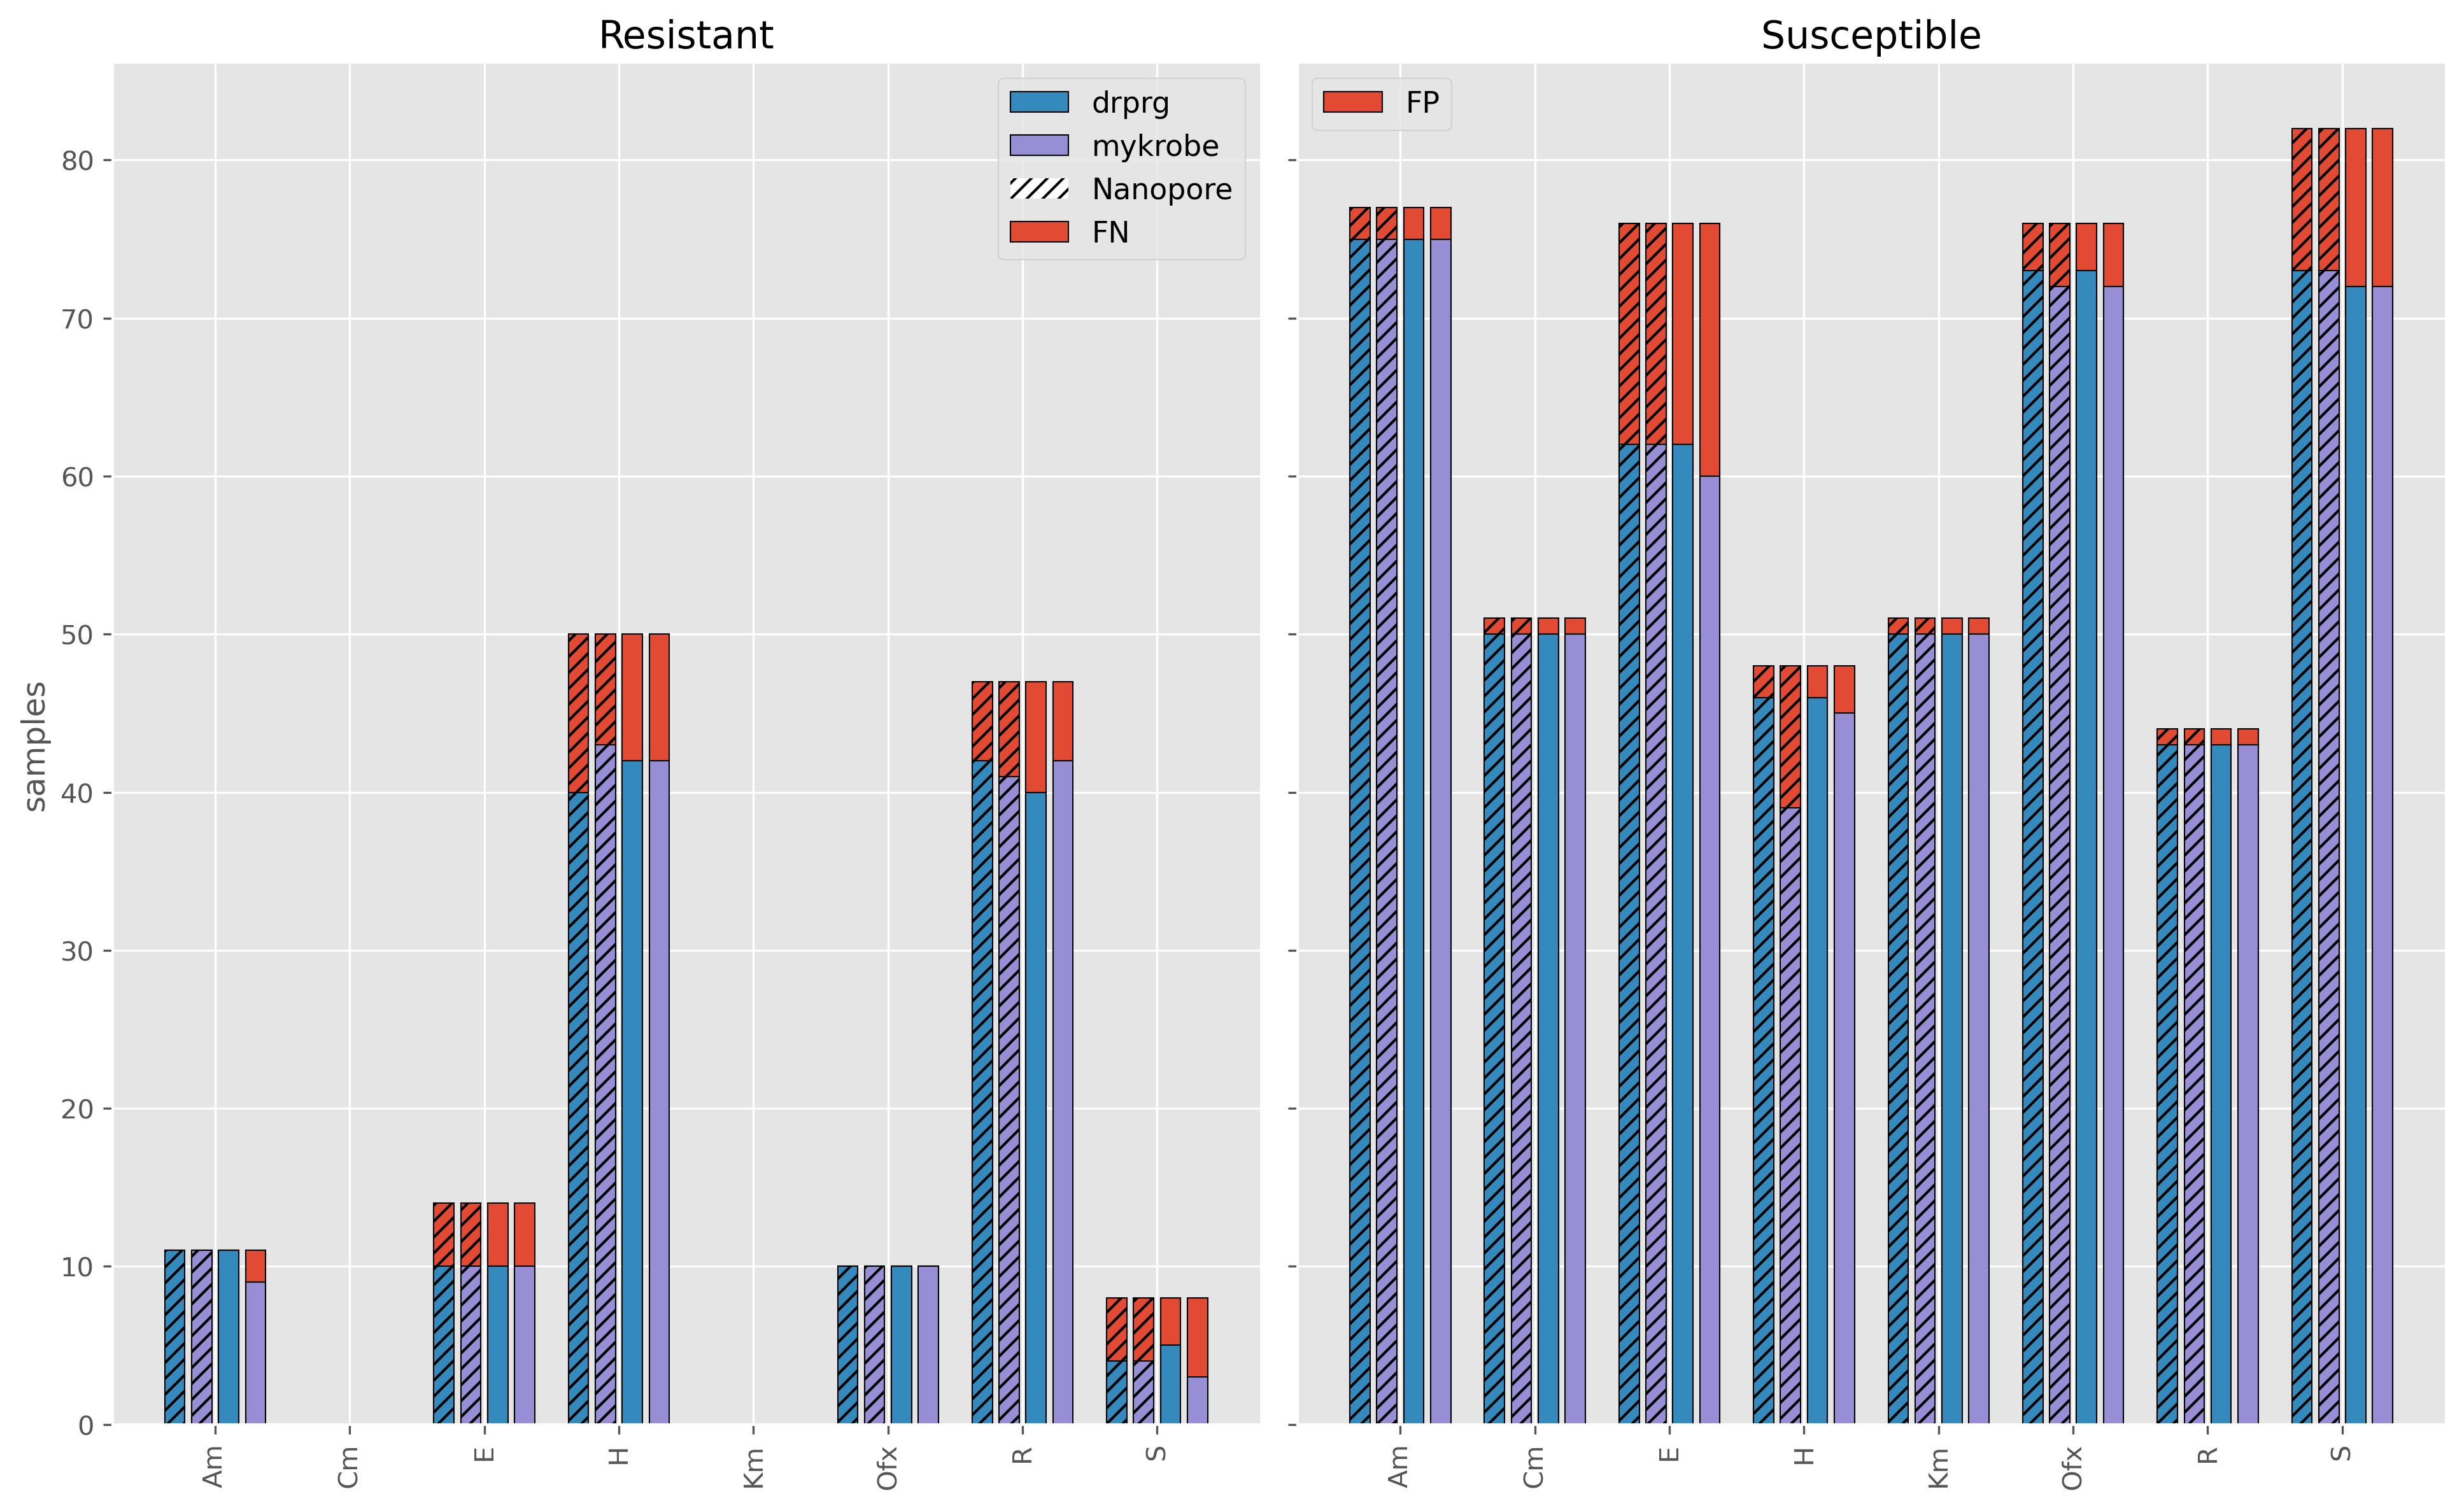

In [137]:
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]
red = ggplot_cm[0]
blue = ggplot_cm[1]
black = ggplot_cm[3]
edgecol = "black"
cmap = {}
i = 0
for tool in TOOLS:
    c = ggplot_cm[i]
    if c in (red, black):
        i += 1
        c = ggplot_cm[i]
    cmap[tool] = c
    i += 1

fig, axes = plt.subplots(ncols=2, figsize=(13, 8), dpi=300, sharey=True)
axR = axes.flatten()[0]
axS = axes.flatten()[1]

# plot details
bar_width = 0.15
epsilon = 0.05
line_width = 0.5
alpha = 1.0
hatch = "////"

all_positions = []
for i, (tech, tool) in enumerate(product(TECHS, TOOLS)):
    tps = [pheno_cms[(d, tech, tool)].tp for d in PHENO_DRUGS]
    fps = [pheno_cms[(d, tech, tool)].fp for d in PHENO_DRUGS]
    tns = [pheno_cms[(d, tech, tool)].tn for d in PHENO_DRUGS]
    fns = [pheno_cms[(d, tech, tool)].fn for d in PHENO_DRUGS]
    
    positions = [p + ((bar_width + epsilon) * i) for p in np.arange(len(tps))]
    all_positions.append(positions)
    
    colour = cmap[tool]

    # resistance bar plots
    tps_bar = axR.bar(
        positions,
        tps,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fns_bar = axR.bar(
        positions,
        fns,
        bar_width,
        bottom=tps,
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )

    # susceptible bar plots
    tns_bar = axS.bar(
        positions,
        tns,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fps_bar = axS.bar(
        positions,
        fps,
        bar_width,
        bottom=tns,
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    
    if tech == "nanopore":
        for bar in tps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in tns_bar.patches:
            bar.set_hatch(hatch)
    else:
        tps_bar.set_label(tool)

fps_bar.set_label("FP")
fns_bar.set_label("FN")
labels = [drug_abbrev[d] for d in PHENO_DRUGS]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=90)
axR.set_ylabel("samples")
axR.set_xticks(label_pos)
axR.set_xticklabels(axS.get_xticklabels(), rotation=90)
axR.set_title("Resistant")
axS.set_title("Susceptible")

axS.legend(loc="best", prop={"size": 11})
leghandles, leglabels = axR.get_legend_handles_labels()
from matplotlib.patches import Patch
hatch_leghandle = Patch(facecolor='white', hatch=hatch)
leghandles.insert(2, hatch_leghandle)
leglabels.insert(2, "Nanopore")
axR.legend(leghandles, leglabels, loc="best", prop={"size": 11})
sns.despine()
plt.tight_layout()

In [138]:
set(pheno.drug)

{'amikacin',
 'amikacin-lpa',
 'capreomycin',
 'capreomycin-lpa',
 'ciprofloxacin-lpa',
 'ethambutol',
 'ethambutol-lpa',
 'ethionamide',
 'isoniazid',
 'isoniazid-lpa',
 'kanamycin',
 'kanamycin-lpa',
 'moxifloxacin',
 'moxifloxacin-lpa',
 'ofloxacin',
 'ofloxacin-lpa',
 'pas',
 'pyrazinamide',
 'rifampicin',
 'rifampicin-lpa',
 'streptomycin',
 'thioacetazone'}

In [139]:
drug = "isoniazid"
for sample in set(clf_df.query("classification == 'FP' and drug == @drug and tool == 'mykrobe'")["sample"]):
    lpa = f"{drug}-lpa"
    print(pheno.query("sample == @sample and drug in (@drug, @lpa)"))

                          sample           drug phenotype
sample   drug                                            
mada_148 isoniazid      mada_148      isoniazid         S
         isoniazid-lpa  mada_148  isoniazid-lpa         S
                          sample           drug phenotype
sample   drug                                            
mada_117 isoniazid      mada_117      isoniazid         S
         isoniazid-lpa  mada_117  isoniazid-lpa         R
                      sample           drug phenotype
sample drug                                          
R28581 isoniazid      R28581      isoniazid         S
       isoniazid-lpa  R28581  isoniazid-lpa         S
                      sample           drug phenotype
sample drug                                          
R36431 isoniazid      R36431      isoniazid         S
       isoniazid-lpa  R36431  isoniazid-lpa         R
                          sample           drug phenotype
sample   drug                                 

In [140]:
clf_df.query("drug == 'ethambutol' and tool == 'mykrobe'").groupby(["site", "classification"]).count()

sample  drug  technology  coverage  tool
site         classification                                          
madagascar   FN                   8     8           8         8     8
             FP                  30    30          30        30    30
             TN                 120   120         120       120   120
             TP                  20    20          20        20    20
south_africa TN                   2     2           2         2     2

In [141]:
for name, group in clf_df.query("classification == 'FN' and drug == 'isoniazid'").groupby("sample"):
    print(name)
    print(group)
    print("----")

mada_1-11
         sample       drug classification technology  coverage     tool  \
558   mada_1-11  isoniazid             FN   illumina      60.0  mykrobe   
1203  mada_1-11  isoniazid             FN   nanopore     150.0  mykrobe   
1712  mada_1-11  isoniazid             FN   illumina      60.0    drprg   
2357  mada_1-11  isoniazid             FN   nanopore     150.0    drprg   

            site  
558   madagascar  
1203  madagascar  
1712  madagascar  
2357  madagascar  
----
mada_1-12
         sample       drug classification technology  coverage     tool  \
446   mada_1-12  isoniazid             FN   illumina     60.00  mykrobe   
1091  mada_1-12  isoniazid             FN   nanopore    104.12  mykrobe   
1613  mada_1-12  isoniazid             FN   illumina     60.00    drprg   
2258  mada_1-12  isoniazid             FN   nanopore    104.12    drprg   

            site  
446   madagascar  
1091  madagascar  
1613  madagascar  
2258  madagascar  
----
mada_1-17
         sample   

In [142]:
clf_df.query("sample == 'R32929'")

,sample,drug,classification,technology,coverage,tool,site
20,R32929,ofloxacin,TP,illumina,60.00,mykrobe,south_africa
21,R32929,amikacin,TP,illumina,60.00,mykrobe,south_africa
665,R32929,ofloxacin,TP,nanopore,53.78,mykrobe,south_africa
666,R32929,amikacin,TP,nanopore,53.78,mykrobe,south_africa
1309,R32929,ofloxacin,TP,illumina,60.00,drprg,south_africa
1310,R32929,amikacin,TP,illumina,60.00,drprg,south_africa
1954,R32929,ofloxacin,TP,nanopore,53.78,drprg,south_africa
1955,R32929,amikacin,TP,nanopore,53.78,drprg,south_africa


In [143]:
fig.savefig("pheno_concordance_plot.png")

In [144]:
counts = clf_df.groupby(["drug", "tool", "technology", "classification"])["sample"].count()
table = summary.set_index(["drug", "tech", "tool", "metric"])["value"].unstack().reset_index()
for clf in ["TP", "FP", "FN", "TN"]:
    table[clf] = [
        counts[d, tool, tech, clf] if (d, tool, tech, clf) in counts else 0
        for d, tech, tool in product(PHENO_DRUGS, TECHS, TOOLS)
    ]

for k in ["drug", "tech", "tool"]:
    table[k] = table[k].str.capitalize()

table.fillna("-", inplace=True)
summary_cols = ["drug", "tech", "tool", "PPV", "NPV", "FNR", "FPR", "TP", "TN", "FN", "FP"]
table = table[summary_cols]
table.rename(columns={"tech": "technology"}, inplace=True)

This table summarises the results visualised above in Figure 2

In [145]:
rows = []
ci_str = (
    lambda tup: f"{tup[0]:.1%} ({tup[1]*100:.1f}-{tup[2]:.1%})"
    if tup[0] is not None
    else "-"
)
for i, row in table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    npv = cm.npv()
    ppv = cm.ppv()
    vme = cm.fnr()
    me = cm.fpr()
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (
            row["drug"].capitalize(),
            row["technology"],
            row["tool"],
            fn_str,
            fp_str,
            ci_str(vme),
            ci_str(me),
            ci_str(ppv),
            ci_str(npv),
        )
    )
pretty_cols = [
    "Drug",
    "Technology",
    "Tool",
    "FN(R)",
    "FP(S)",
    "FNR(95% CI)",
    "FPR(95% CI)",
    "PPV(95% CI)",
    "NPV(95% CI)",
]
table = pd.DataFrame(rows, columns=pretty_cols)
table

,Drug,Technology,Tool,FN(R),FP(S),FNR(95% CI),FPR(95% CI),PPV(95% CI),NPV(95% CI)
0,Amikacin,Illumina,Drprg,0(11),2(77),0.0% (0.0-25.9%),2.6% (0.7-9.0%),84.6% (57.8-95.7%),100.0% (95.1-100.0%)
1,Amikacin,Illumina,Mykrobe,0(11),2(77),0.0% (0.0-25.9%),2.6% (0.7-9.0%),84.6% (57.8-95.7%),100.0% (95.1-100.0%)
2,Amikacin,Nanopore,Drprg,0(11),2(77),0.0% (0.0-25.9%),2.6% (0.7-9.0%),84.6% (57.8-95.7%),100.0% (95.1-100.0%)
3,Amikacin,Nanopore,Mykrobe,2(11),2(77),18.2% (5.1-47.7%),2.6% (0.7-9.0%),81.8% (52.3-94.9%),97.4% (91.0-99.3%)
4,Capreomycin,Illumina,Drprg,0(0),1(51),-,2.0% (0.3-10.3%),0.0% (0.0-79.3%),100.0% (92.9-100.0%)
5,Capreomycin,Illumina,Mykrobe,0(0),1(51),-,2.0% (0.3-10.3%),0.0% (0.0-79.3%),100.0% (92.9-100.0%)
6,Capreomycin,Nanopore,Drprg,0(0),1(51),-,2.0% (0.3-10.3%),0.0% (0.0-79.3%),100.0% (92.9-100.0%)
7,Capreomycin,Nanopore,Mykrobe,0(0),1(51),-,2.0% (0.3-10.3%),0.0% (0.0-79.3%),100.0% (92.9-100.0%)
8,Ethambutol,Illumina,Drprg,4(14),14(76),28.6% (11.7-54.6%),18.4% (11.3-28.6%),41.7% (24.5-61.2%),93.9% (85.4-97.6%)
9,Ethambutol,Illumina,Mykrobe,4(14),14(76),28.6% (11.7-54.6%),18.4% (11.3-28.6%),41.7% (24.5-61.2%),93.9% (85.4-97.6%)


## Table 1 Comparison of drug resistance predictions with culture-based phenotype

For this comparison, we assume the drug susceptibility testing phenotype is correct and evaluate mykrobe Illumina and Nanopore resistance predictions accordingly. Pyrazinamide and Moxifloxacin are excluded as phenotype information is only available for 1 sample.

FN=false negative; R=number of resistant samples; FP=false positive; S=number of susceptible samples; FNR=false negative rate; FPR=false positive rate; PPV=positive predictive value; NPV=negative predictive value; CI=Wilson score confidence interval

In [146]:
print(table.to_markdown(index=False))

| Drug         | Technology   | Tool    | FN(R)   | FP(S)   | FNR(95% CI)        | FPR(95% CI)        | PPV(95% CI)        | NPV(95% CI)          |
|:-------------|:-------------|:--------|:--------|:--------|:-------------------|:-------------------|:-------------------|:---------------------|
| Amikacin     | Illumina     | Drprg   | 0(11)   | 2(77)   | 0.0% (0.0-25.9%)   | 2.6% (0.7-9.0%)    | 84.6% (57.8-95.7%) | 100.0% (95.1-100.0%) |
| Amikacin     | Illumina     | Mykrobe | 0(11)   | 2(77)   | 0.0% (0.0-25.9%)   | 2.6% (0.7-9.0%)    | 84.6% (57.8-95.7%) | 100.0% (95.1-100.0%) |
| Amikacin     | Nanopore     | Drprg   | 0(11)   | 2(77)   | 0.0% (0.0-25.9%)   | 2.6% (0.7-9.0%)    | 84.6% (57.8-95.7%) | 100.0% (95.1-100.0%) |
| Amikacin     | Nanopore     | Mykrobe | 2(11)   | 2(77)   | 18.2% (5.1-47.7%)  | 2.6% (0.7-9.0%)    | 81.8% (52.3-94.9%) | 97.4% (91.0-99.3%)   |
| Capreomycin  | Illumina     | Drprg   | 0(0)    | 1(51)   | -                  | 2.0% (0.3-10.3%)   | 0.0% (0.

In [147]:
print(table.to_latex(index=False))

\begin{tabular}{lllllllll}
\toprule
        Drug & Technology &    Tool &  FN(R) &  FP(S) &        FNR(95\% CI) &        FPR(95\% CI) &        PPV(95\% CI) &          NPV(95\% CI) \\
\midrule
    Amikacin &   Illumina &   Drprg &  0(11) &  2(77) &   0.0\% (0.0-25.9\%) &    2.6\% (0.7-9.0\%) & 84.6\% (57.8-95.7\%) & 100.0\% (95.1-100.0\%) \\
    Amikacin &   Illumina & Mykrobe &  0(11) &  2(77) &   0.0\% (0.0-25.9\%) &    2.6\% (0.7-9.0\%) & 84.6\% (57.8-95.7\%) & 100.0\% (95.1-100.0\%) \\
    Amikacin &   Nanopore &   Drprg &  0(11) &  2(77) &   0.0\% (0.0-25.9\%) &    2.6\% (0.7-9.0\%) & 84.6\% (57.8-95.7\%) & 100.0\% (95.1-100.0\%) \\
    Amikacin &   Nanopore & Mykrobe &  2(11) &  2(77) &  18.2\% (5.1-47.7\%) &    2.6\% (0.7-9.0\%) & 81.8\% (52.3-94.9\%) &   97.4\% (91.0-99.3\%) \\
 Capreomycin &   Illumina &   Drprg &   0(0) &  1(51) &                  - &   2.0\% (0.3-10.3\%) &   0.0\% (0.0-79.3\%) & 100.0\% (92.9-100.0\%) \\
 Capreomycin &   Illumina & Mykrobe &   0(0) &  1(51) &

In [148]:
# table.to_csv(snakemake.output.pheno_concordance_csv, na_rep="-", index=False)

In [149]:
clf_df

,sample,drug,classification,technology,coverage,tool,site
0,R21408,ofloxacin,TN,illumina,60.00,mykrobe,south_africa
1,R21408,amikacin,TN,illumina,60.00,mykrobe,south_africa
2,R23887,ofloxacin,TN,illumina,60.00,mykrobe,south_africa
3,R23887,isoniazid,TP,illumina,60.00,mykrobe,south_africa
4,R23887,amikacin,TN,illumina,60.00,mykrobe,south_africa
...,...,...,...,...,...,...,...
2575,mada_1-16,ethambutol,TN,nanopore,56.54,drprg,madagascar
2576,mada_1-16,streptomycin,TN,nanopore,56.54,drprg,madagascar
2577,mada_1-16,rifampicin,TP,nanopore,56.54,drprg,madagascar
2578,mada_1-16,amikacin,TN,nanopore,56.54,drprg,madagascar


In [150]:
data = []

step = 10
tech = "nanopore"
start = round_down_to_base(
    clf_df.query("technology==@tech")["coverage"].min(), base=step
)
stop = (
    round_up_to_base(clf_df.query("technology==@tech")["coverage"].max(), base=step)
    + step
)
coverages = np.arange(start=start, stop=stop, step=step)
for i, covg in enumerate(coverages[:-1]):
    next_cov = coverages[i + 1]
    subdf = clf_df.query(
        "coverage > @covg and coverage <= @next_cov and technology == @tech"
    )
    n_samples = len(set(subdf['sample']))
    for tool in TOOLS:
        s = subdf.query("tool == @tool").value_counts(subset="classification")
        cm = ConfusionMatrix.from_series(s)
        total = sum(cm.ravel())
        
        data.append((covg, "FP", cm.fp / total, tech, n_samples, tool))
        data.append((covg, "TP", cm.tp / total, tech, n_samples, tool))
        data.append((covg, "FN", cm.fn / total, tech, n_samples, tool))
        data.append((covg, "TN", cm.tn / total, tech, n_samples, tool))


tech = "illumina"
start = round_down_to_base(
    clf_df.query("technology==@tech")["coverage"].min(), base=step
)
stop = round_up_to_base(clf_df.query("technology==@tech")["coverage"].max(), base=step)
coverages = np.arange(start=start, stop=stop, step=step)
for i, covg in enumerate(coverages[:-1]):
    next_cov = coverages[i + 1]
    subdf = clf_df.query(
        "coverage > @covg and coverage <= @next_cov and technology == @tech"
    )
    n_samples = len(set(subdf['sample']))
    for tool in TOOLS:
        s = subdf.query("tool == @tool").value_counts(subset="classification")
        cm = ConfusionMatrix.from_series(s)
        total = sum(cm.ravel())
        
        data.append((covg, "FP", cm.fp / total, tech, n_samples, tool))
        data.append((covg, "TP", cm.tp / total, tech, n_samples, tool))
        data.append((covg, "FN", cm.fn / total, tech, n_samples, tool))
        data.append((covg, "TN", cm.tn / total, tech, n_samples, tool))

summary = pd.DataFrame(
    data, columns=["coverage", "classification", "proportion", "technology", "total", "tool"]
)

Effect of Nanopore read depth on mykrobe phenotype prediction. Each point indicates the proportion (y-axis) of classifications of that type at the read depth (x-axis). Read depth is "binned". That is, read depth 40 is all samples with a read depth greater than 40 and less than or equal to 50. FP - false positive; TN - true negative; etc.

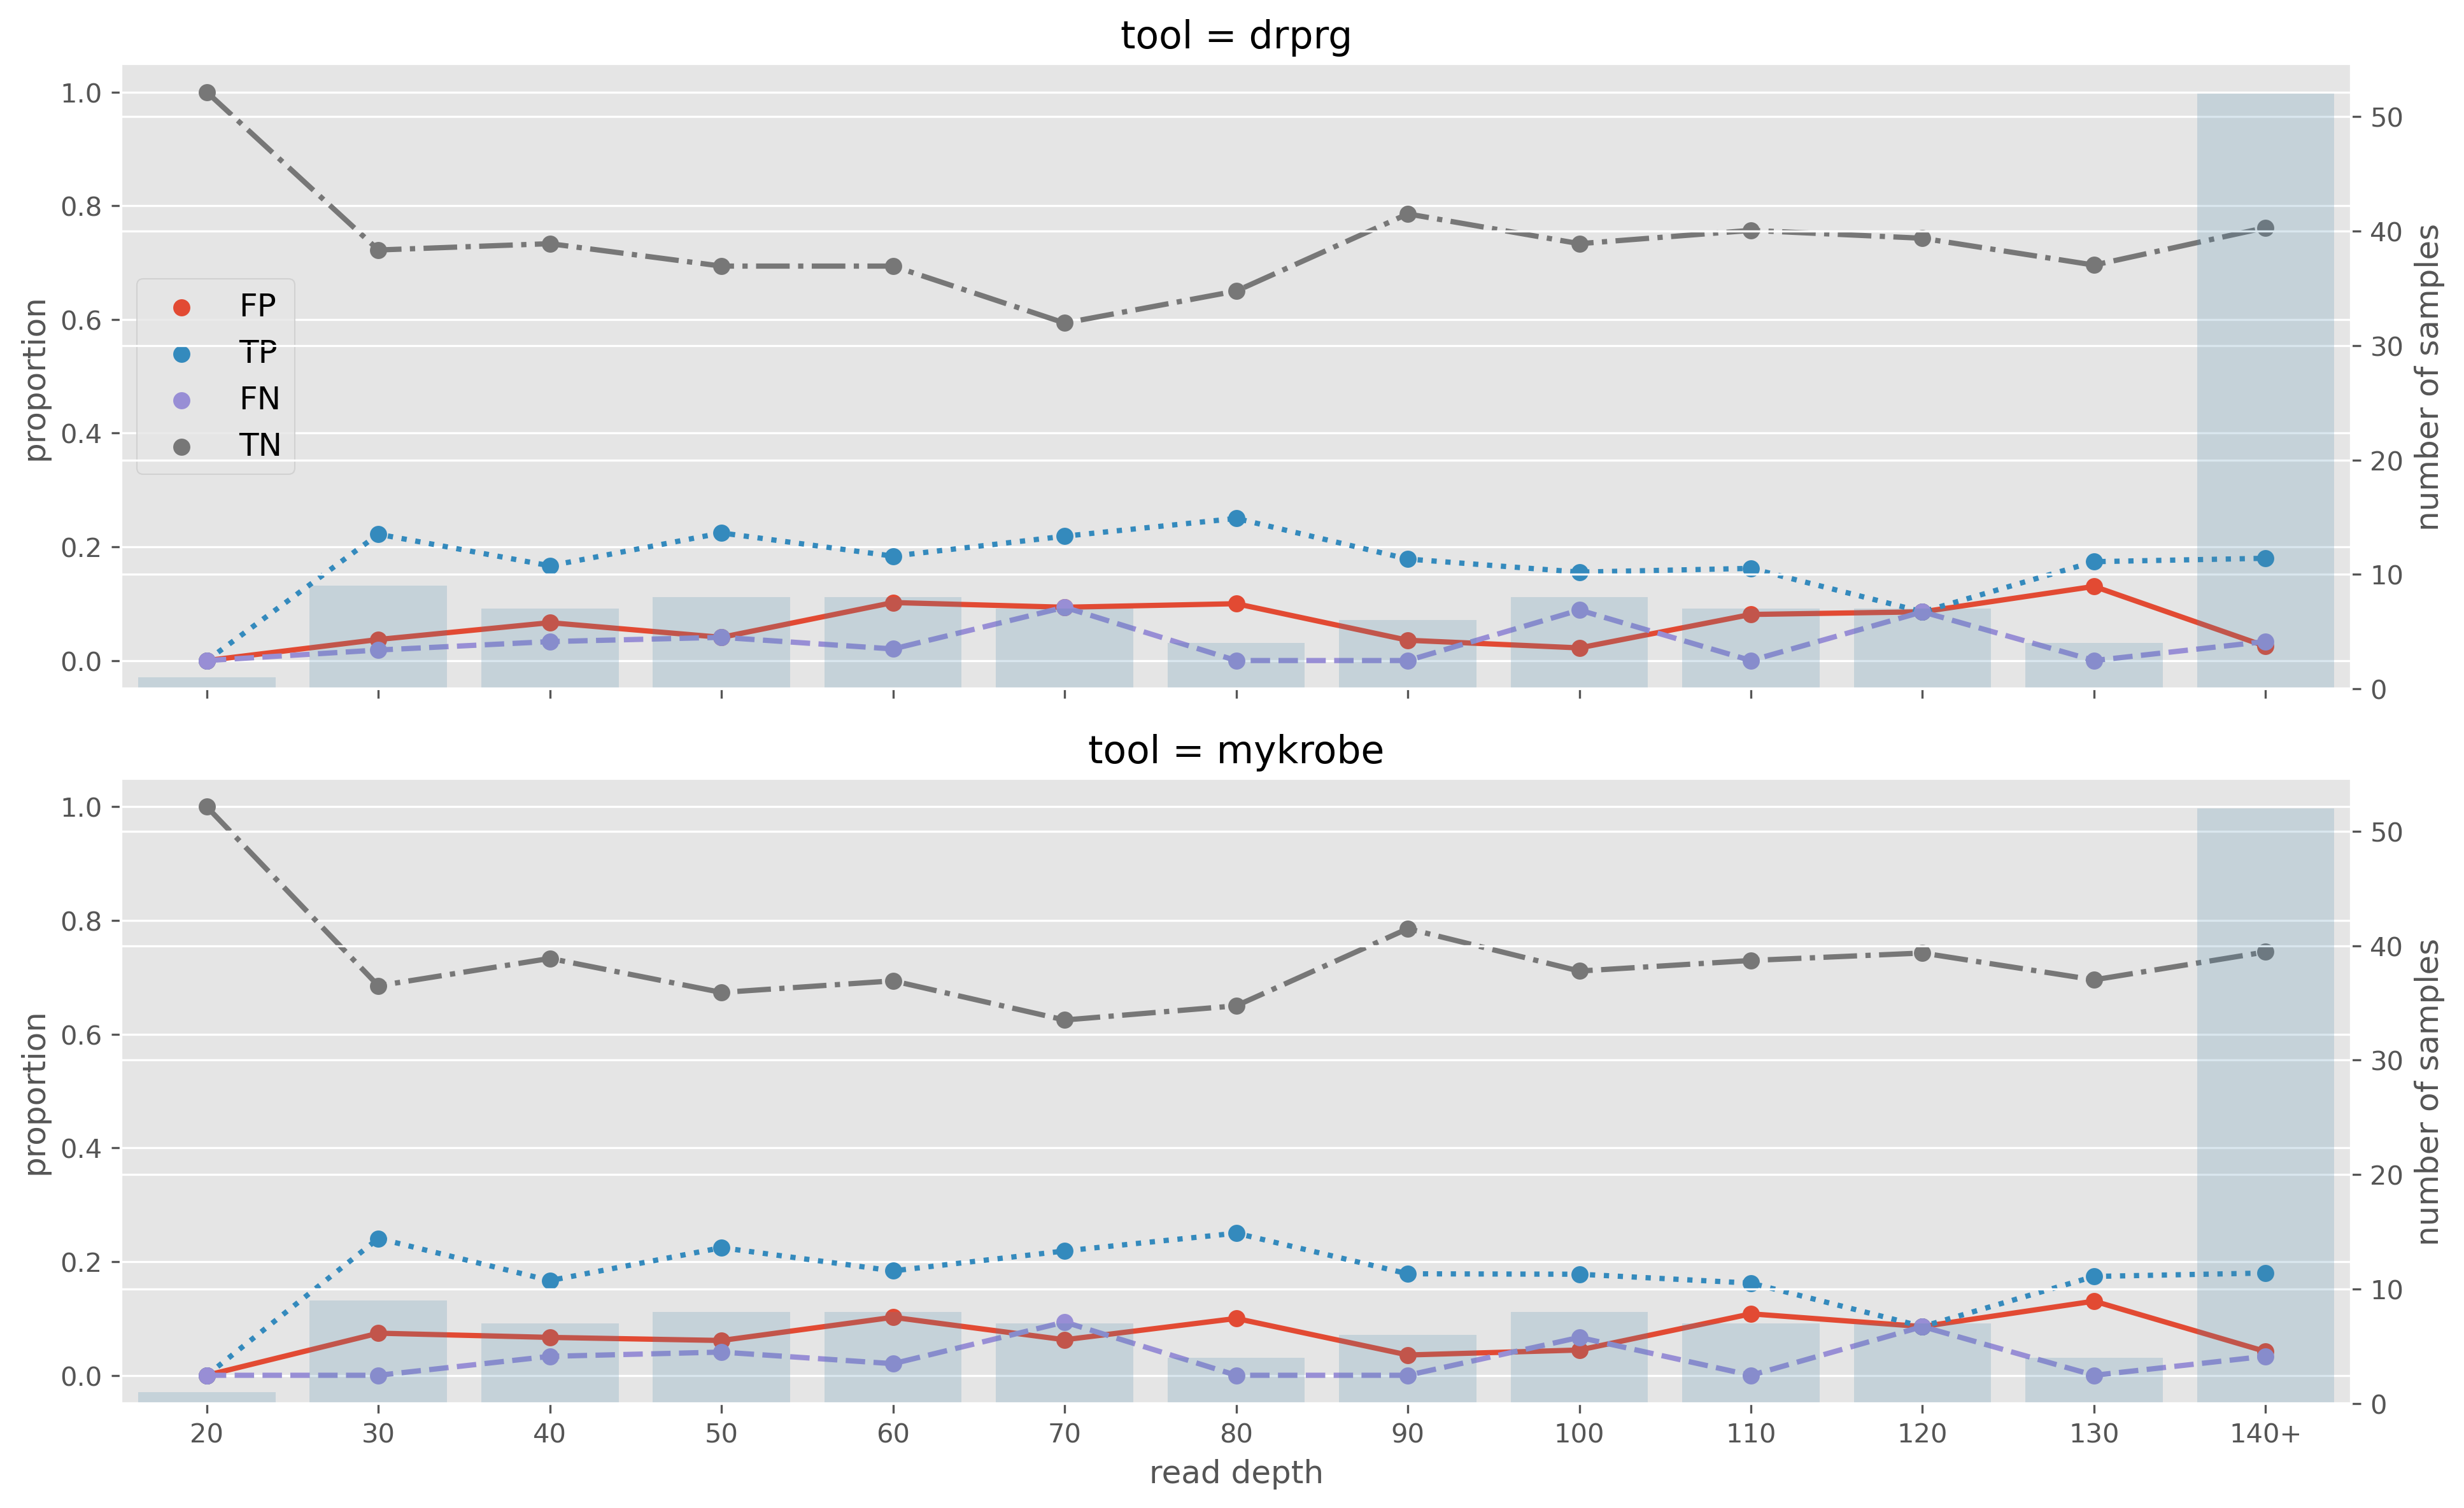

In [151]:
with sns.plotting_context(rc={"lines.linewidth": 1.1}):
    fig, axes = plt.subplots(nrows=len(TOOLS), figsize=(13, 8), dpi=300, sharex=True)
    
    for tool, ax in zip(TOOLS, axes.flatten()):
        x = "coverage"
        y = "proportion"
        hue = "classification"
        tech = "nanopore"
        linestyles = ["solid", "dotted", "dashed", "dashdot"]
        data = summary.query("technology == @tech and tool == @tool")
        sns.pointplot(
            data=data,
            x=x,
            y=y,
            hue=hue,
            ax=ax,
            linestyles=linestyles,
            alpha=0.9,
        )
        ax.set_xlabel("")
        ax.set(title=f"tool = {tool}")

        ax2 = ax.twinx()
        sns.barplot(data=data, x=x, y="total", ax=ax2, color=blue, alpha=0.2)
        ax2.set_ylabel("number of samples")
        ax.legend(loc="center left", fontsize=12)
        
    xlabels = ax2.get_xticklabels()
    xlabels[-1].set_text(xlabels[-1].get_text() + "+")
    ax2.set_xticklabels(xlabels)
    ax.set_xlabel("read depth")
    ax.get_legend().remove()
    plt.tight_layout()

In [152]:
# fig.savefig(snakemake.output.pheno_coverage_plot)

# Concordance of mykrobe Nanopore resistance prediction with Illumina
Having proven mykrobe's ability to predict resistance for select drugs with ONT, we look at the concordance of ONT-based predictions with Illumina-based ones. We aim to answer to main questions here: 1) Are ONT predictions concordant with Illumina and 2) does ONT depth of coverage impact prediction capabilities and, if so, what is the coverage threshold for this impact?
We will also discuss the causes for any discrepencies and look to COMPASS/bcftools calls for adjudication if possible.

For the figure/table of this section it might suffice to just have a table like the one in Table 1. of the recent mykrobe paper with a row for each drug and columns showing TPs, FNs etc. along with VME (95% CI), ME (95% CI), PPV and NPV

In [153]:
classes = sorted(set(calls["classification"]))
conf_mxs = defaultdict()

for drug, tool, tech in product(DRUGS, TOOLS, TECHS):
    if (tech, tool) == ("illumina", "mykrobe"):
        continue
    s = calls.query("drug == @drug and tool == @tool and tech == @tech").value_counts(subset=["classification"])
    cm = ConfusionMatrix.from_series(s)
    conf_mxs[(drug, tech, tool)] = cm

metrics = []
for (drug, tech, tool), cm in conf_mxs.items():
    #     sensitivity = cm.sensitivity()
    #     specificity = cm.specificity()
    ppv = cm.ppv()[0]
    npv = cm.npv()[0]
    vme = cm.fnr()[0]
    me = cm.fpr()[0]
    metrics.append((drug, ppv, npv, vme, me, tech, tool))

summary_cols = ["drug", "PPV", "NPV", "FNR", "FPR", "tech", "tool"]

summary = pd.DataFrame(metrics, columns=summary_cols).melt(
    id_vars=["drug", "tool", "tech"], var_name="metric"
)
table = summary.set_index(["drug", "tool", "tech", "metric"])["value"].unstack().reset_index()
table = table[summary_cols]

counts = calls.groupby(["drug", "tool", "tech", "classification"])["sample"].count()
for clf in ["TP", "FP", "FN", "TN"]:
    table[clf] = [
        counts[d, tool, tech, clf] if (d, tool, tech, clf) in counts else 0
        for d, tech, tool in product(DRUGS, TECHS, TOOLS)
        if (tech, tool) != ("illumina", "mykrobe")
    ]

for k in ["drug", "tech", "tool"]:
    table[k] = table[k].str.capitalize()

table

metric,drug,PPV,NPV,FNR,FPR,tech,tool,TP,FP,FN,TN
0,Amikacin,0.857143,1.000000,0.000000,0.014493,Illumina,Drprg,12,2,0,136
1,Amikacin,0.857143,1.000000,0.000000,0.014493,Nanopore,Drprg,12,2,0,136
2,Amikacin,0.857143,1.000000,0.000000,0.014493,Nanopore,Mykrobe,12,2,0,136
3,Capreomycin,0.857143,1.000000,0.000000,0.014493,Illumina,Drprg,12,2,0,136
4,Capreomycin,0.857143,1.000000,0.000000,0.014493,Nanopore,Drprg,12,2,0,136
5,Capreomycin,0.857143,1.000000,0.000000,0.014493,Nanopore,Mykrobe,12,2,0,136
6,Ciprofloxacin,1.000000,0.992537,0.058824,0.000000,Illumina,Drprg,16,0,1,133
7,Ciprofloxacin,1.000000,0.992537,0.058824,0.000000,Nanopore,Drprg,16,0,1,133
8,Ciprofloxacin,1.000000,0.992537,0.058824,0.000000,Nanopore,Mykrobe,16,0,1,133
9,Ethambutol,1.000000,0.969072,0.053571,0.000000,Illumina,Drprg,53,0,3,94


In [154]:
print(table.to_markdown(index=False))

| drug          |      PPV |      NPV |       FNR |       FPR | tech     | tool    |   TP |   FP |   FN |   TN |
|:--------------|---------:|---------:|----------:|----------:|:---------|:--------|-----:|-----:|-----:|-----:|
| Amikacin      | 0.857143 | 1        | 0         | 0.0144928 | Illumina | Drprg   |   12 |    2 |    0 |  136 |
| Amikacin      | 0.857143 | 1        | 0         | 0.0144928 | Nanopore | Drprg   |   12 |    2 |    0 |  136 |
| Amikacin      | 0.857143 | 1        | 0         | 0.0144928 | Nanopore | Mykrobe |   12 |    2 |    0 |  136 |
| Capreomycin   | 0.857143 | 1        | 0         | 0.0144928 | Illumina | Drprg   |   12 |    2 |    0 |  136 |
| Capreomycin   | 0.857143 | 1        | 0         | 0.0144928 | Nanopore | Drprg   |   12 |    2 |    0 |  136 |
| Capreomycin   | 0.857143 | 1        | 0         | 0.0144928 | Nanopore | Mykrobe |   12 |    2 |    0 |  136 |
| Ciprofloxacin | 1        | 0.992537 | 0.0588235 | 0         | Illumina | Drprg   |   16 |    0

In [155]:
print(table.to_latex(index=False))

\begin{tabular}{lrrrrllrrrr}
\toprule
         drug &      PPV &      NPV &      FNR &      FPR &     tech &    tool &  TP &  FP &  FN &  TN \\
\midrule
     Amikacin & 0.857143 & 1.000000 & 0.000000 & 0.014493 & Illumina &   Drprg &  12 &   2 &   0 & 136 \\
     Amikacin & 0.857143 & 1.000000 & 0.000000 & 0.014493 & Nanopore &   Drprg &  12 &   2 &   0 & 136 \\
     Amikacin & 0.857143 & 1.000000 & 0.000000 & 0.014493 & Nanopore & Mykrobe &  12 &   2 &   0 & 136 \\
  Capreomycin & 0.857143 & 1.000000 & 0.000000 & 0.014493 & Illumina &   Drprg &  12 &   2 &   0 & 136 \\
  Capreomycin & 0.857143 & 1.000000 & 0.000000 & 0.014493 & Nanopore &   Drprg &  12 &   2 &   0 & 136 \\
  Capreomycin & 0.857143 & 1.000000 & 0.000000 & 0.014493 & Nanopore & Mykrobe &  12 &   2 &   0 & 136 \\
Ciprofloxacin & 1.000000 & 0.992537 & 0.058824 & 0.000000 & Illumina &   Drprg &  16 &   0 &   1 & 133 \\
Ciprofloxacin & 1.000000 & 0.992537 & 0.058824 & 0.000000 & Nanopore &   Drprg &  16 &   0 &   1 & 133 \\

In [156]:
rows = []
ci_str = (
    lambda tup: f"{tup[0]:.1%} ({tup[1]*100:.1f}-{tup[2]:.1%})"
    if tup[0] is not None
    else "-"
)
for i, row in table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    npv = cm.npv()
    ppv = cm.ppv()
    vme = cm.fnr()
    me = cm.fpr()
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (row["drug"], row["tool"], row["tech"], fn_str, fp_str, ci_str(vme), ci_str(me), ci_str(ppv), ci_str(npv))
    )
pretty_cols = [
    "Drug",
    "Tool",
    "Technology",
    "FN(R)",
    "FP(S)",
    "FNR(95% CI)",
    "FPR(95% CI)",
    "PPV(95% CI)",
    "NPV(95% CI)",
]
table = pd.DataFrame(rows, columns=pretty_cols)
table

,Drug,Tool,Technology,FN(R),FP(S),FNR(95% CI),FPR(95% CI),PPV(95% CI),NPV(95% CI)
0,Amikacin,Drprg,Illumina,0(12),2(138),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
1,Amikacin,Drprg,Nanopore,0(12),2(138),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
2,Amikacin,Mykrobe,Nanopore,0(12),2(138),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
3,Capreomycin,Drprg,Illumina,0(12),2(138),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
4,Capreomycin,Drprg,Nanopore,0(12),2(138),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
5,Capreomycin,Mykrobe,Nanopore,0(12),2(138),0.0% (0.0-24.2%),1.4% (0.4-5.1%),85.7% (60.1-96.0%),100.0% (97.3-100.0%)
6,Ciprofloxacin,Drprg,Illumina,1(17),0(133),5.9% (1.0-27.0%),0.0% (0.0-2.8%),100.0% (80.6-100.0%),99.3% (95.9-99.9%)
7,Ciprofloxacin,Drprg,Nanopore,1(17),0(133),5.9% (1.0-27.0%),0.0% (0.0-2.8%),100.0% (80.6-100.0%),99.3% (95.9-99.9%)
8,Ciprofloxacin,Mykrobe,Nanopore,1(17),0(133),5.9% (1.0-27.0%),0.0% (0.0-2.8%),100.0% (80.6-100.0%),99.3% (95.9-99.9%)
9,Ethambutol,Drprg,Illumina,3(56),0(94),5.4% (1.8-14.6%),0.0% (0.0-3.9%),100.0% (93.2-100.0%),96.9% (91.3-98.9%)


## Table 2 Comparison of Nanopore drug resistance predictions with Illumina predictions

For this comparison, we assume the mykrobe resistance prediction from Illumina data is correct and evaluate the Nanopore prediction accordingly.

FN=false negative; R=number of resistant samples; FP=false positive; S=number of susceptible samples; FNR=false negative rate; FPR=false positive rate; PPV=positive predictive value; NPV=negative predictive value; CI=Wilson score confidence interval

In [157]:
print(table.to_markdown(index=False))

| Drug          | Tool    | Technology   | FN(R)   | FP(S)   | FNR(95% CI)       | FPR(95% CI)       | PPV(95% CI)          | NPV(95% CI)          |
|:--------------|:--------|:-------------|:--------|:--------|:------------------|:------------------|:---------------------|:---------------------|
| Amikacin      | Drprg   | Illumina     | 0(12)   | 2(138)  | 0.0% (0.0-24.2%)  | 1.4% (0.4-5.1%)   | 85.7% (60.1-96.0%)   | 100.0% (97.3-100.0%) |
| Amikacin      | Drprg   | Nanopore     | 0(12)   | 2(138)  | 0.0% (0.0-24.2%)  | 1.4% (0.4-5.1%)   | 85.7% (60.1-96.0%)   | 100.0% (97.3-100.0%) |
| Amikacin      | Mykrobe | Nanopore     | 0(12)   | 2(138)  | 0.0% (0.0-24.2%)  | 1.4% (0.4-5.1%)   | 85.7% (60.1-96.0%)   | 100.0% (97.3-100.0%) |
| Capreomycin   | Drprg   | Illumina     | 0(12)   | 2(138)  | 0.0% (0.0-24.2%)  | 1.4% (0.4-5.1%)   | 85.7% (60.1-96.0%)   | 100.0% (97.3-100.0%) |
| Capreomycin   | Drprg   | Nanopore     | 0(12)   | 2(138)  | 0.0% (0.0-24.2%)  | 1.4% (0.4-5.1%)   | 85.

In [158]:
print(table.to_latex(index=False))

\begin{tabular}{lllllllll}
\toprule
         Drug &    Tool & Technology &  FN(R) &   FP(S) &       FNR(95\% CI) &       FPR(95\% CI) &          PPV(95\% CI) &          NPV(95\% CI) \\
\midrule
     Amikacin &   Drprg &   Illumina &  0(12) &  2(138) &  0.0\% (0.0-24.2\%) &   1.4\% (0.4-5.1\%) &   85.7\% (60.1-96.0\%) & 100.0\% (97.3-100.0\%) \\
     Amikacin &   Drprg &   Nanopore &  0(12) &  2(138) &  0.0\% (0.0-24.2\%) &   1.4\% (0.4-5.1\%) &   85.7\% (60.1-96.0\%) & 100.0\% (97.3-100.0\%) \\
     Amikacin & Mykrobe &   Nanopore &  0(12) &  2(138) &  0.0\% (0.0-24.2\%) &   1.4\% (0.4-5.1\%) &   85.7\% (60.1-96.0\%) & 100.0\% (97.3-100.0\%) \\
  Capreomycin &   Drprg &   Illumina &  0(12) &  2(138) &  0.0\% (0.0-24.2\%) &   1.4\% (0.4-5.1\%) &   85.7\% (60.1-96.0\%) & 100.0\% (97.3-100.0\%) \\
  Capreomycin &   Drprg &   Nanopore &  0(12) &  2(138) &  0.0\% (0.0-24.2\%) &   1.4\% (0.4-5.1\%) &   85.7\% (60.1-96.0\%) & 100.0\% (97.3-100.0\%) \\
  Capreomycin & Mykrobe &   Nanopore &  0

In [159]:
# table.to_csv(snakemake.output.illumina_concordance_csv, na_rep="-", index=False)

## Figure 4 
Number of resistant (left) and susceptible (right) genotypes correctly identified by mykrobe from Illumina (blue) and Nanopore (purple) data from the same samples. The genotypes are predictions from mykrobe with Illumina data. The red bars indicate missed (FN) or incorrect (FP) predictions. The x-axis shows the drugs with available phenotype data that mykrobe also makes predictions for. E - ethambutol; H - isoniazid; Z - pyrazinamide; R - rifampicin; S - streptomycin; Km - kanamycin; Am - amikacin; Ofx - ofloxacin; Cm - capreomycin; Mfx - moxifloxacin.

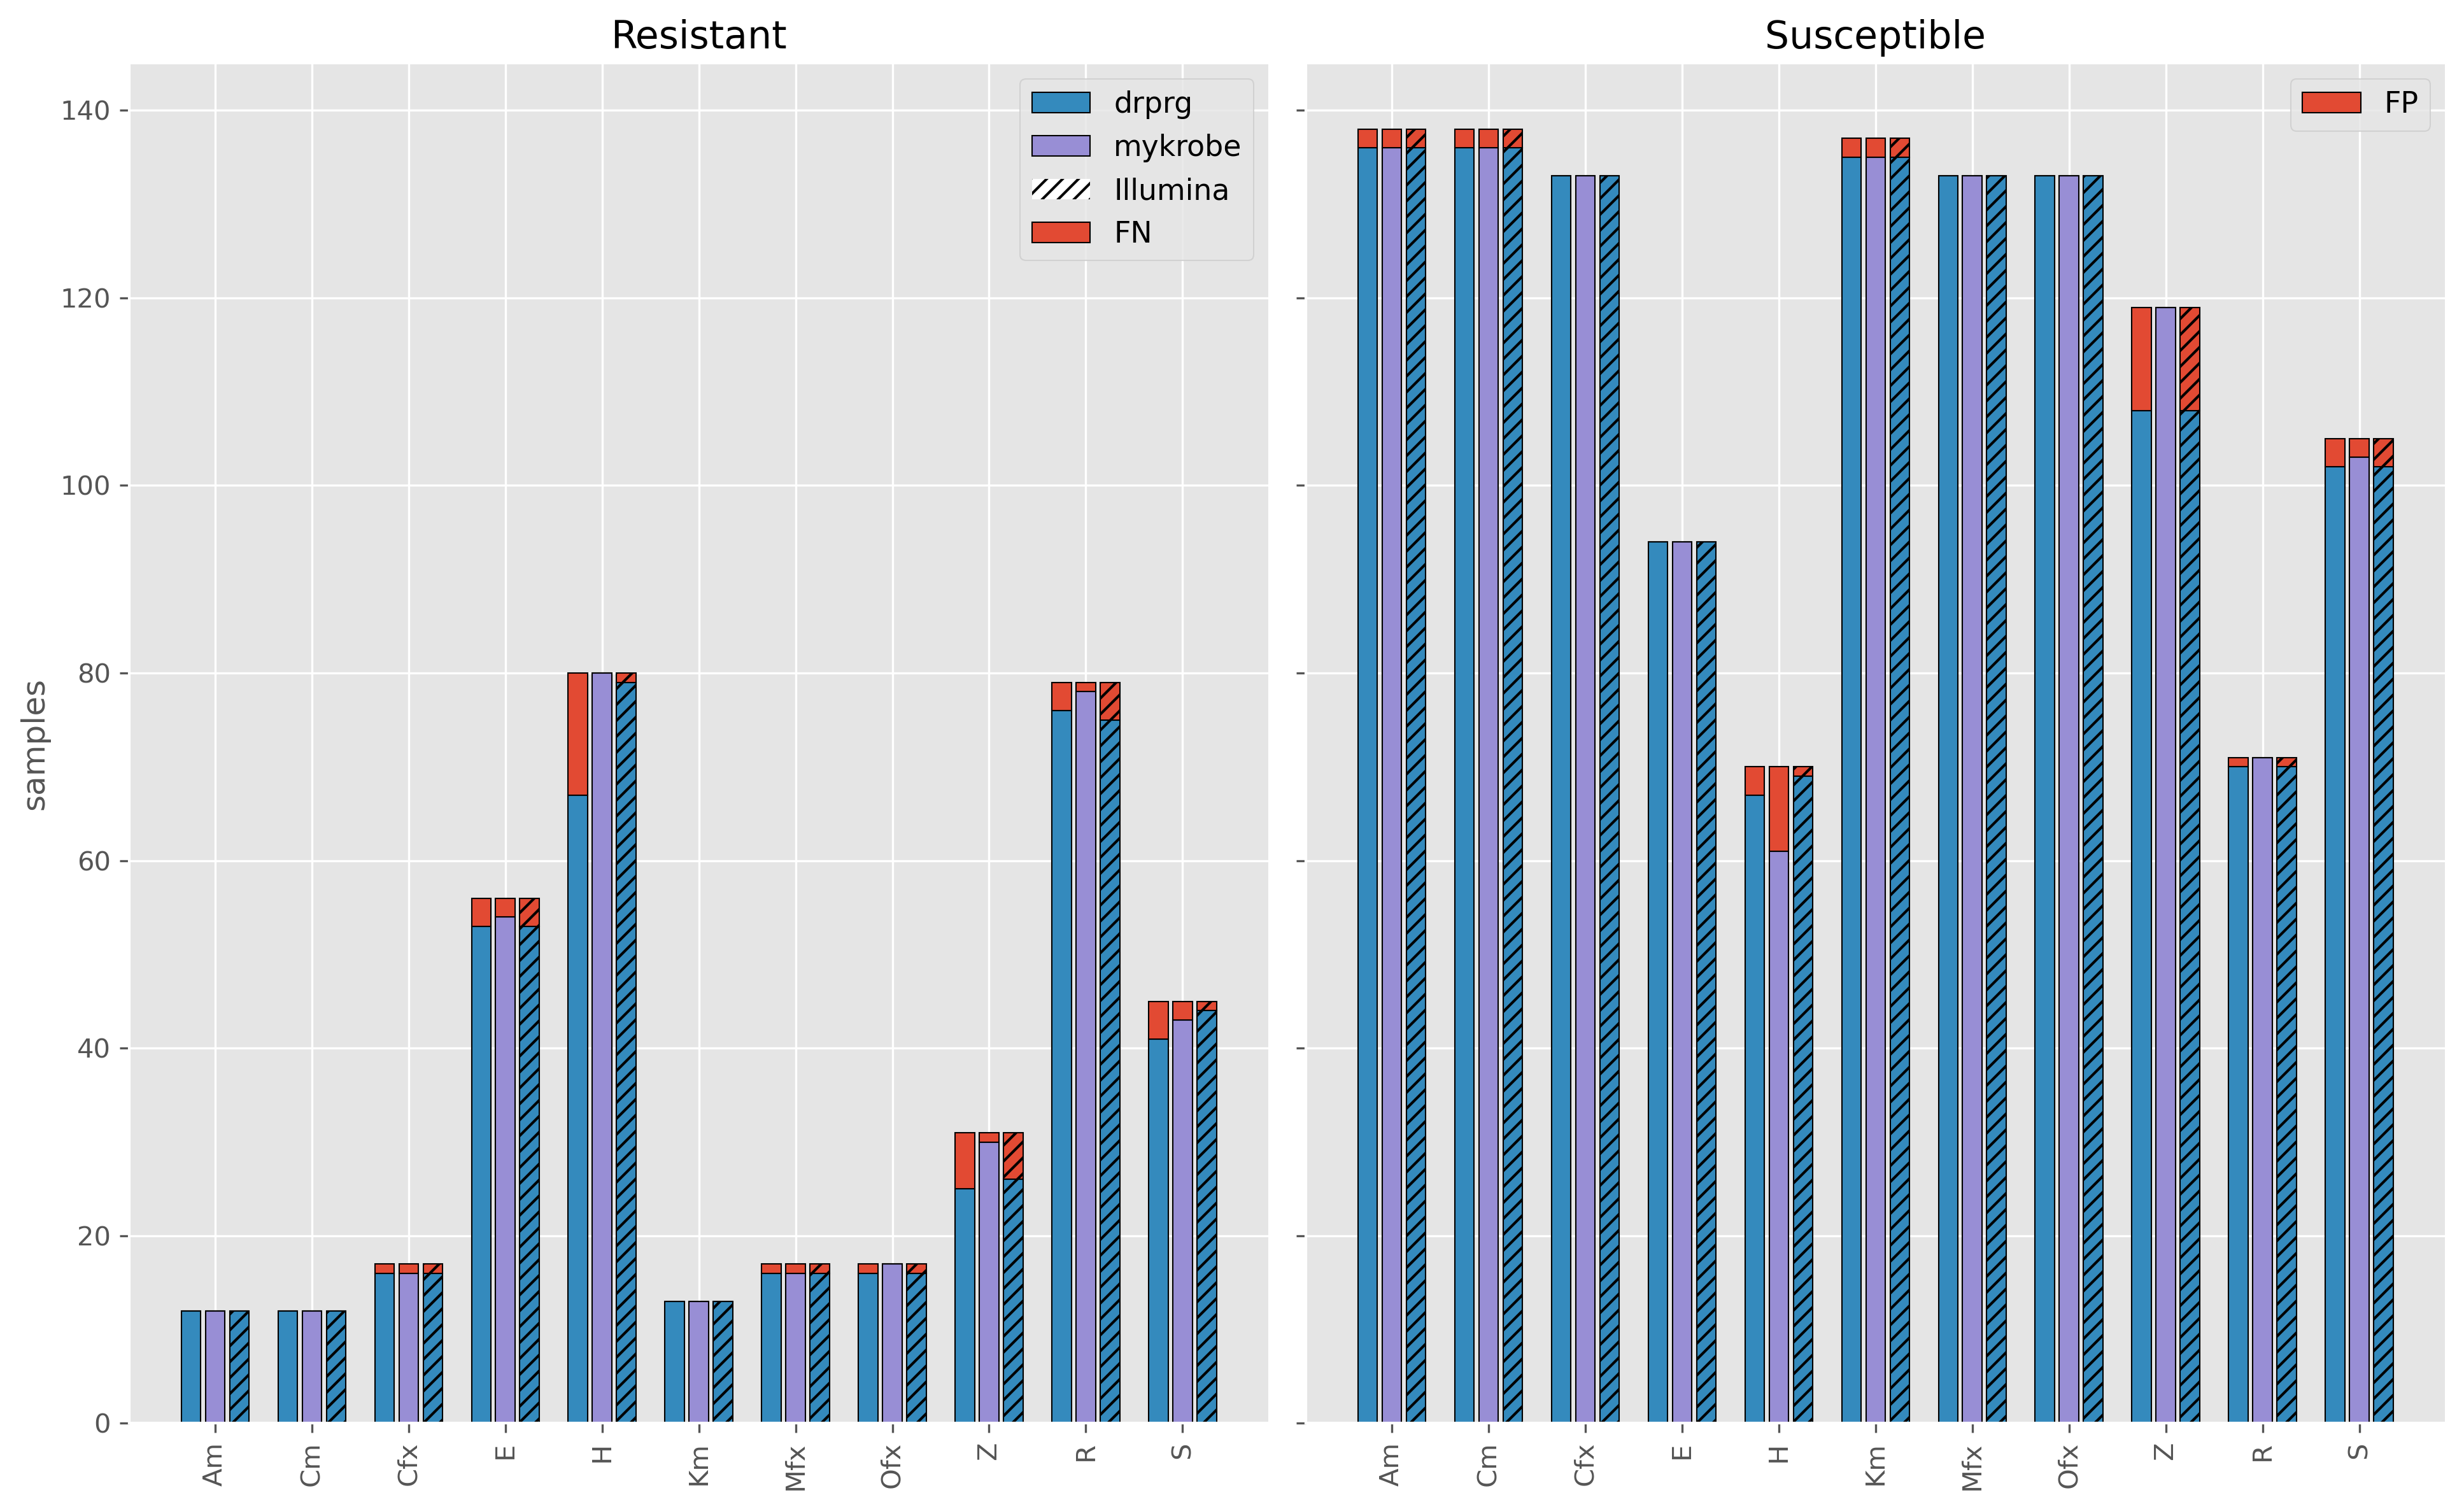

In [160]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 8), dpi=300, sharey=True)
axR = axes.flatten()[0]
axS = axes.flatten()[1]

# plot details
bar_width = 0.2
epsilon = 0.05
line_width = 0.5
alpha = 1.0
hatch = "////"

all_positions = []
for i, (tech, tool) in enumerate(product(TECHS, TOOLS)):
    if (tech, tool) == ("illumina", "mykrobe"):
        continue
        
    tps = [conf_mxs[(d, tech, tool)].tp for d in DRUGS]
    fps = [conf_mxs[(d, tech, tool)].fp for d in DRUGS]
    tns = [conf_mxs[(d, tech, tool)].tn for d in DRUGS]
    fns = [conf_mxs[(d, tech, tool)].fn for d in DRUGS]
    
    positions = [p + ((bar_width + epsilon) * i) for p in np.arange(len(tps))]
    all_positions.append(positions)
    
    colour = cmap[tool]

    # resistance bar plots
    tps_bar = axR.bar(
        positions,
        tps,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fns_bar = axR.bar(
        positions,
        fns,
        bar_width,
        bottom=tps,
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )

    # susceptible bar plots
    tns_bar = axS.bar(
        positions,
        tns,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fps_bar = axS.bar(
        positions,
        fps,
        bar_width,
        bottom=tns,
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    
    if tech == "illumina":
        for bar in tps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in tns_bar.patches:
            bar.set_hatch(hatch)
    else:
        tps_bar.set_label(tool)

    if i == 0:
        fps_bar.set_label("FP")
        fns_bar.set_label("FN")
        
labels = [drug_abbrev[d.lower()] for d in DRUGS]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=90)
axR.set_ylabel("samples")
axR.set_xticks(label_pos)
axR.set_xticklabels(axS.get_xticklabels(), rotation=90)
axR.set_title("Resistant")
axS.set_title("Susceptible")

axS.legend(loc="best", prop={"size": 11})
leghandles, leglabels = axR.get_legend_handles_labels()
from matplotlib.patches import Patch
hatch_leghandle = Patch(facecolor='white', hatch=hatch)
leghandles.insert(3, hatch_leghandle)
leglabels.insert(3, "Illumina")
leglabels.insert(3, leglabels.pop(1))
leghandles.insert(3, leghandles.pop(1))
axR.legend(leghandles, leglabels, loc="best", prop={"size": 11})

sns.despine()
plt.tight_layout()

In [161]:
calls

,drug,classification,true_call,test_call,sample,tool,tech,site
0,Ofloxacin,TN,S,S,18_0622434,mykrobe,illumina,birmingham
1,Moxifloxacin,TN,S,S,18_0622434,mykrobe,illumina,birmingham
2,Isoniazid,TP,R,R,18_0622434,mykrobe,illumina,birmingham
3,Kanamycin,TN,S,S,18_0622434,mykrobe,illumina,birmingham
4,Ethambutol,TN,S,S,18_0622434,mykrobe,illumina,birmingham
...,...,...,...,...,...,...,...,...
6595,Ciprofloxacin,TN,S,S,mada_1-16,drprg,nanopore,madagascar
6596,Pyrazinamide,TN,S,S,mada_1-16,drprg,nanopore,madagascar
6597,Rifampicin,TP,R,R,mada_1-16,drprg,nanopore,madagascar
6598,Amikacin,TN,S,S,mada_1-16,drprg,nanopore,madagascar


In [162]:
for name, group in calls.query("classification == 'FN' and drug == 'Pyrazinamide'").groupby("sample"):
    print(name)
    print(group)
    print("----")

R23146
              drug classification true_call test_call  sample   tool  \
5210  Pyrazinamide             FN         R         S  R23146  drprg   

          tech          site  
5210  nanopore  south_africa  
----
R24120
              drug classification true_call test_call  sample   tool  \
3901  Pyrazinamide             FN         R         S  R24120  drprg   

          tech          site  
3901  illumina  south_africa  
----
R26778
              drug classification true_call test_call  sample   tool  \
5408  Pyrazinamide             FN         R         S  R26778  drprg   

          tech          site  
5408  nanopore  south_africa  
----
R26791
              drug classification true_call test_call  sample   tool  \
5518  Pyrazinamide             FN         R         F  R26791  drprg   

          tech          site  
5518  nanopore  south_africa  
----
R28980
              drug classification true_call test_call  sample   tool  \
5386  Pyrazinamide             FN         R  

# Calling novel variants

In this section we look at how `drprg`'s ability to call novel variants impact the concordance with phenotype

In [163]:
novel_clf = []
minor_is_susceptible = False
unknown_is_resistant = True
failed_is_resistant = True
classifier = Classifier(unknown_is_resistant=unknown_is_resistant, minor_is_susceptible=minor_is_susceptible, failed_is_resistant=failed_is_resistant)

for ix, row in calls.iterrows():
    drug = row["drug"].lower()
    if drug in ignore_drugs:
        continue

    sample = row["sample"]
    try:
        ph = pheno.loc[(sample, drug), "phenotype"]
        if pd.isna(ph).all():
            continue
        else:
            truth = Prediction(ph[0])
    except KeyError:
        continue
    
    tech = row["tech"]
    if tech == "illumina":
        covg = covdf.loc[sample]["illumina_covg"]
    else:
        covg = covdf.loc[sample]["nanopore_covg"]
    
    pred = Prediction(row["test_call"])    
    clf = classifier.from_predictions(truth, pred)

    novel_clf.append((sample, drug, str(clf), tech, covg, row["tool"], row["site"], pred))

In [164]:
novel_df = pd.DataFrame(
    novel_clf, columns=["sample", "drug", "classification", "technology", "coverage", "tool", "site", "prediction"]
)

In [165]:
novel_cms = defaultdict()

for drug, tech, tool in product(set(clf_df["drug"]), TECHS, TOOLS):
    s = novel_df.query("drug == @drug and technology == @tech and tool == @tool").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    novel_cms[(drug, tech, tool)] = cm

In [166]:
metrics = []
for (drug, tech, tool), cm in novel_cms.items():
        #         sensitivity = cm.sensitivity()
        #         specificity = cm.specificity()
    ppv = cm.ppv()[0]
    npv = cm.npv()[0]
    vme = cm.fnr()[0]
    me = cm.fpr()[0]
    metrics.append((drug, tech, tool, ppv, npv, vme, me))

summary_cols = [
    "drug",
    "tech",
    "tool",
    "PPV",
    "NPV",
    "FNR",
    "FPR",
]

novel_summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug", "tech", "tool"], var_name="metric")

In [167]:
novel_df.query("prediction == @Prediction.Unknown and classification == 'TP'")

,sample,drug,classification,technology,coverage,tool,site,prediction
1423,mada_1-32,ethambutol,TP,illumina,60.00,drprg,madagascar,U
1461,mada_1-18,isoniazid,TP,illumina,60.00,drprg,madagascar,U
1465,mada_1-18,rifampicin,TP,illumina,60.00,drprg,madagascar,U
1548,mada_1-44,streptomycin,TP,illumina,60.00,drprg,madagascar,U
1588,mada_1-33,isoniazid,TP,illumina,60.00,drprg,madagascar,U
1591,mada_1-33,rifampicin,TP,illumina,60.00,drprg,madagascar,U
1617,mada_1-12,rifampicin,TP,illumina,60.00,drprg,madagascar,U
1662,mada_1-7,ethambutol,TP,illumina,60.00,drprg,madagascar,U
1716,mada_1-11,rifampicin,TP,illumina,60.00,drprg,madagascar,U
1807,mada_1-17,isoniazid,TP,illumina,60.00,drprg,madagascar,U


Concordance with phenotype, with novel variant calling

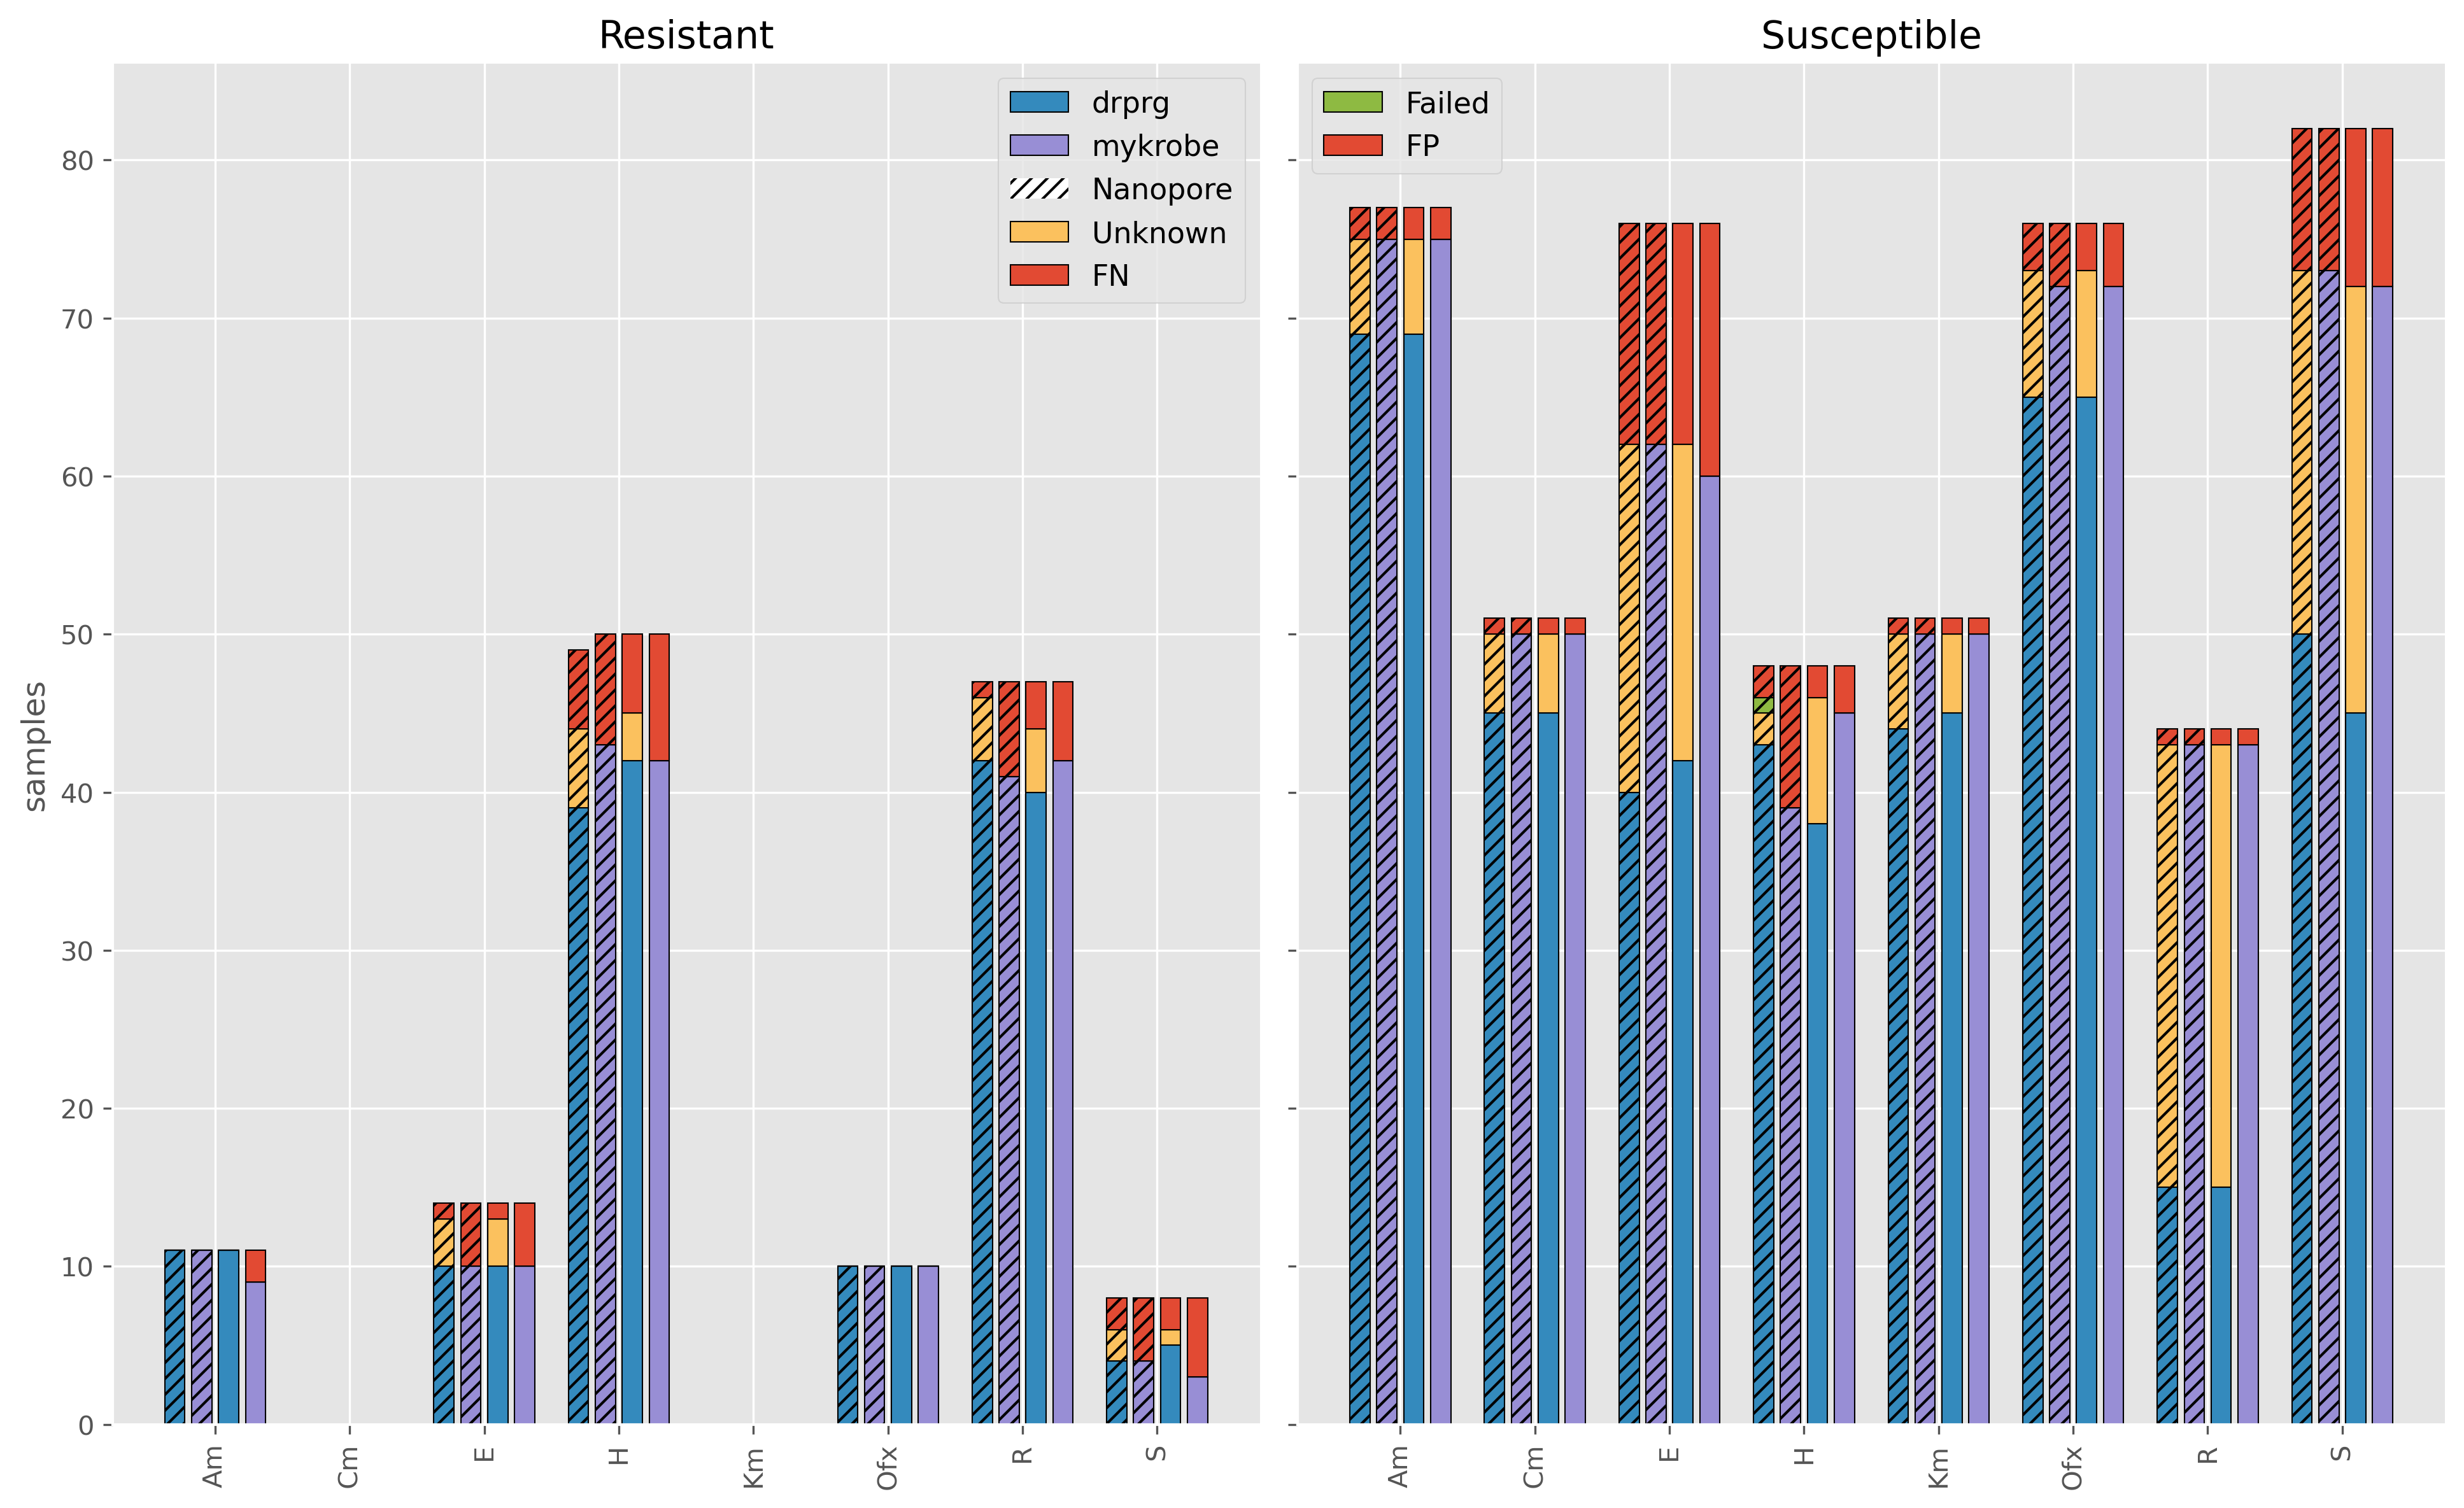

In [168]:
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]
red = ggplot_cm[0]
blue = ggplot_cm[1]
black = ggplot_cm[3]
yellow = ggplot_cm[4]
green = ggplot_cm[5]
edgecol = "black"
cmap = {}
i = 0
for tool in TOOLS:
    c = ggplot_cm[i]
    if c in (red, black, yellow):
        i += 1
        c = ggplot_cm[i]
    cmap[tool] = c
    i += 1

fig, axes = plt.subplots(ncols=2, figsize=(13, 8), dpi=300, sharey=True)
axR = axes.flatten()[0]
axS = axes.flatten()[1]

# plot details
bar_width = 0.15
epsilon = 0.05
line_width = 0.5
alpha = 1.0
hatch = "////"

all_positions = []
for i, (tech, tool) in enumerate(product(TECHS, TOOLS)):
    correct_novel = [
        novel_df.query("prediction == @Prediction.Unknown and classification == 'TP' and technology == @tech and tool == @tool and drug == @d").count()[0]
        for d in PHENO_DRUGS
    ]
    correct_failed = [
        novel_df.query("prediction == @Prediction.Failed and classification == 'TP' and technology == @tech and tool == @tool and drug == @d").count()[0]
        for d in PHENO_DRUGS
    ]
    incorrect_novel = [
        novel_df.query("prediction == @Prediction.Unknown and classification == 'FP'  and technology == @tech and tool == @tool and drug == @d").count()[0]
        for d in PHENO_DRUGS
    ]
    incorrect_failed = [
        novel_df.query("prediction == @Prediction.Failed and classification == 'FP'  and technology == @tech and tool == @tool and drug == @d").count()[0]
        for d in PHENO_DRUGS
    ]
    fps = [novel_cms[(d, tech, tool)].fp - incorrect_novel[i] - incorrect_failed[i] for i, d in enumerate(PHENO_DRUGS)]
    tps = [novel_cms[(d, tech, tool)].tp - correct_novel[i] - incorrect_failed[i] for i, d in enumerate(PHENO_DRUGS)]
    tns = [novel_cms[(d, tech, tool)].tn for d in PHENO_DRUGS]
    fns = [novel_cms[(d, tech, tool)].fn for d in PHENO_DRUGS]
    
    positions = [p + ((bar_width + epsilon) * i) for p in np.arange(len(tps))]
    all_positions.append(positions)
    
    colour = cmap[tool]

    # resistance bar plots
    tps_bar = axR.bar(
        positions,
        tps,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    u_tp_bar = axR.bar(
        positions,
        correct_novel,
        bar_width,
        bottom=tps,
        color=yellow,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    f_tp_bar = axR.bar(
        positions,
        correct_failed,
        bar_width,
        bottom=[x+y for x, y in zip(tps, correct_novel)],
        color=green,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fns_bar = axR.bar(
        positions,
        fns,
        bar_width,
        bottom=[x+y+z for x, y, z in zip(tps, correct_novel, correct_failed)],
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )


    # susceptible bar plots
    tns_bar = axS.bar(
        positions,
        tns,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    u_fp_bar = axS.bar(
        positions,
        incorrect_novel,
        bar_width,
        bottom=tns,
        color=yellow,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    f_fp_bar = axS.bar(
        positions,
        incorrect_failed,
        bar_width,
        bottom=[x+y for x, y in zip(tns, incorrect_novel)],
        color=green,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fps_bar = axS.bar(
        positions,
        fps,
        bar_width,
        bottom=[x+y+z for x, y, z in zip(tns, incorrect_novel, incorrect_failed)],
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    
    if tech == "nanopore":
        for bar in tps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in tns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in u_fp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in u_tp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in f_fp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in f_tp_bar.patches:
            bar.set_hatch(hatch)
    else:
        tps_bar.set_label(tool)

fps_bar.set_label("FP")
fns_bar.set_label("FN")
u_tp_bar.set_label("Unknown")
f_fp_bar.set_label("Failed")
labels = [drug_abbrev[d] for d in PHENO_DRUGS]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=90)
axR.set_ylabel("samples")
axR.set_xticks(label_pos)
axR.set_xticklabels(axS.get_xticklabels(), rotation=90)
axR.set_title("Resistant")
axS.set_title("Susceptible")

axS.legend(loc="best", prop={"size": 11})
leghandles, leglabels = axR.get_legend_handles_labels()
from matplotlib.patches import Patch
hatch_leghandle = Patch(facecolor='white', hatch=hatch)
leghandles.insert(2, hatch_leghandle)
leglabels.insert(2, "Nanopore")
axR.legend(leghandles, leglabels, loc="best", prop={"size": 11})
sns.despine()
plt.tight_layout()

In [169]:
# fig.savefig("novel.frs70.png")

Concordance with mykrobe with novel variant calling

In [174]:
calls.head()

,drug,classification,true_call,test_call,sample,tool,tech,site
0,Ofloxacin,TN,S,S,18_0622434,mykrobe,illumina,birmingham
1,Moxifloxacin,TN,S,S,18_0622434,mykrobe,illumina,birmingham
2,Isoniazid,TP,R,R,18_0622434,mykrobe,illumina,birmingham
3,Kanamycin,TN,S,S,18_0622434,mykrobe,illumina,birmingham
4,Ethambutol,TN,S,S,18_0622434,mykrobe,illumina,birmingham


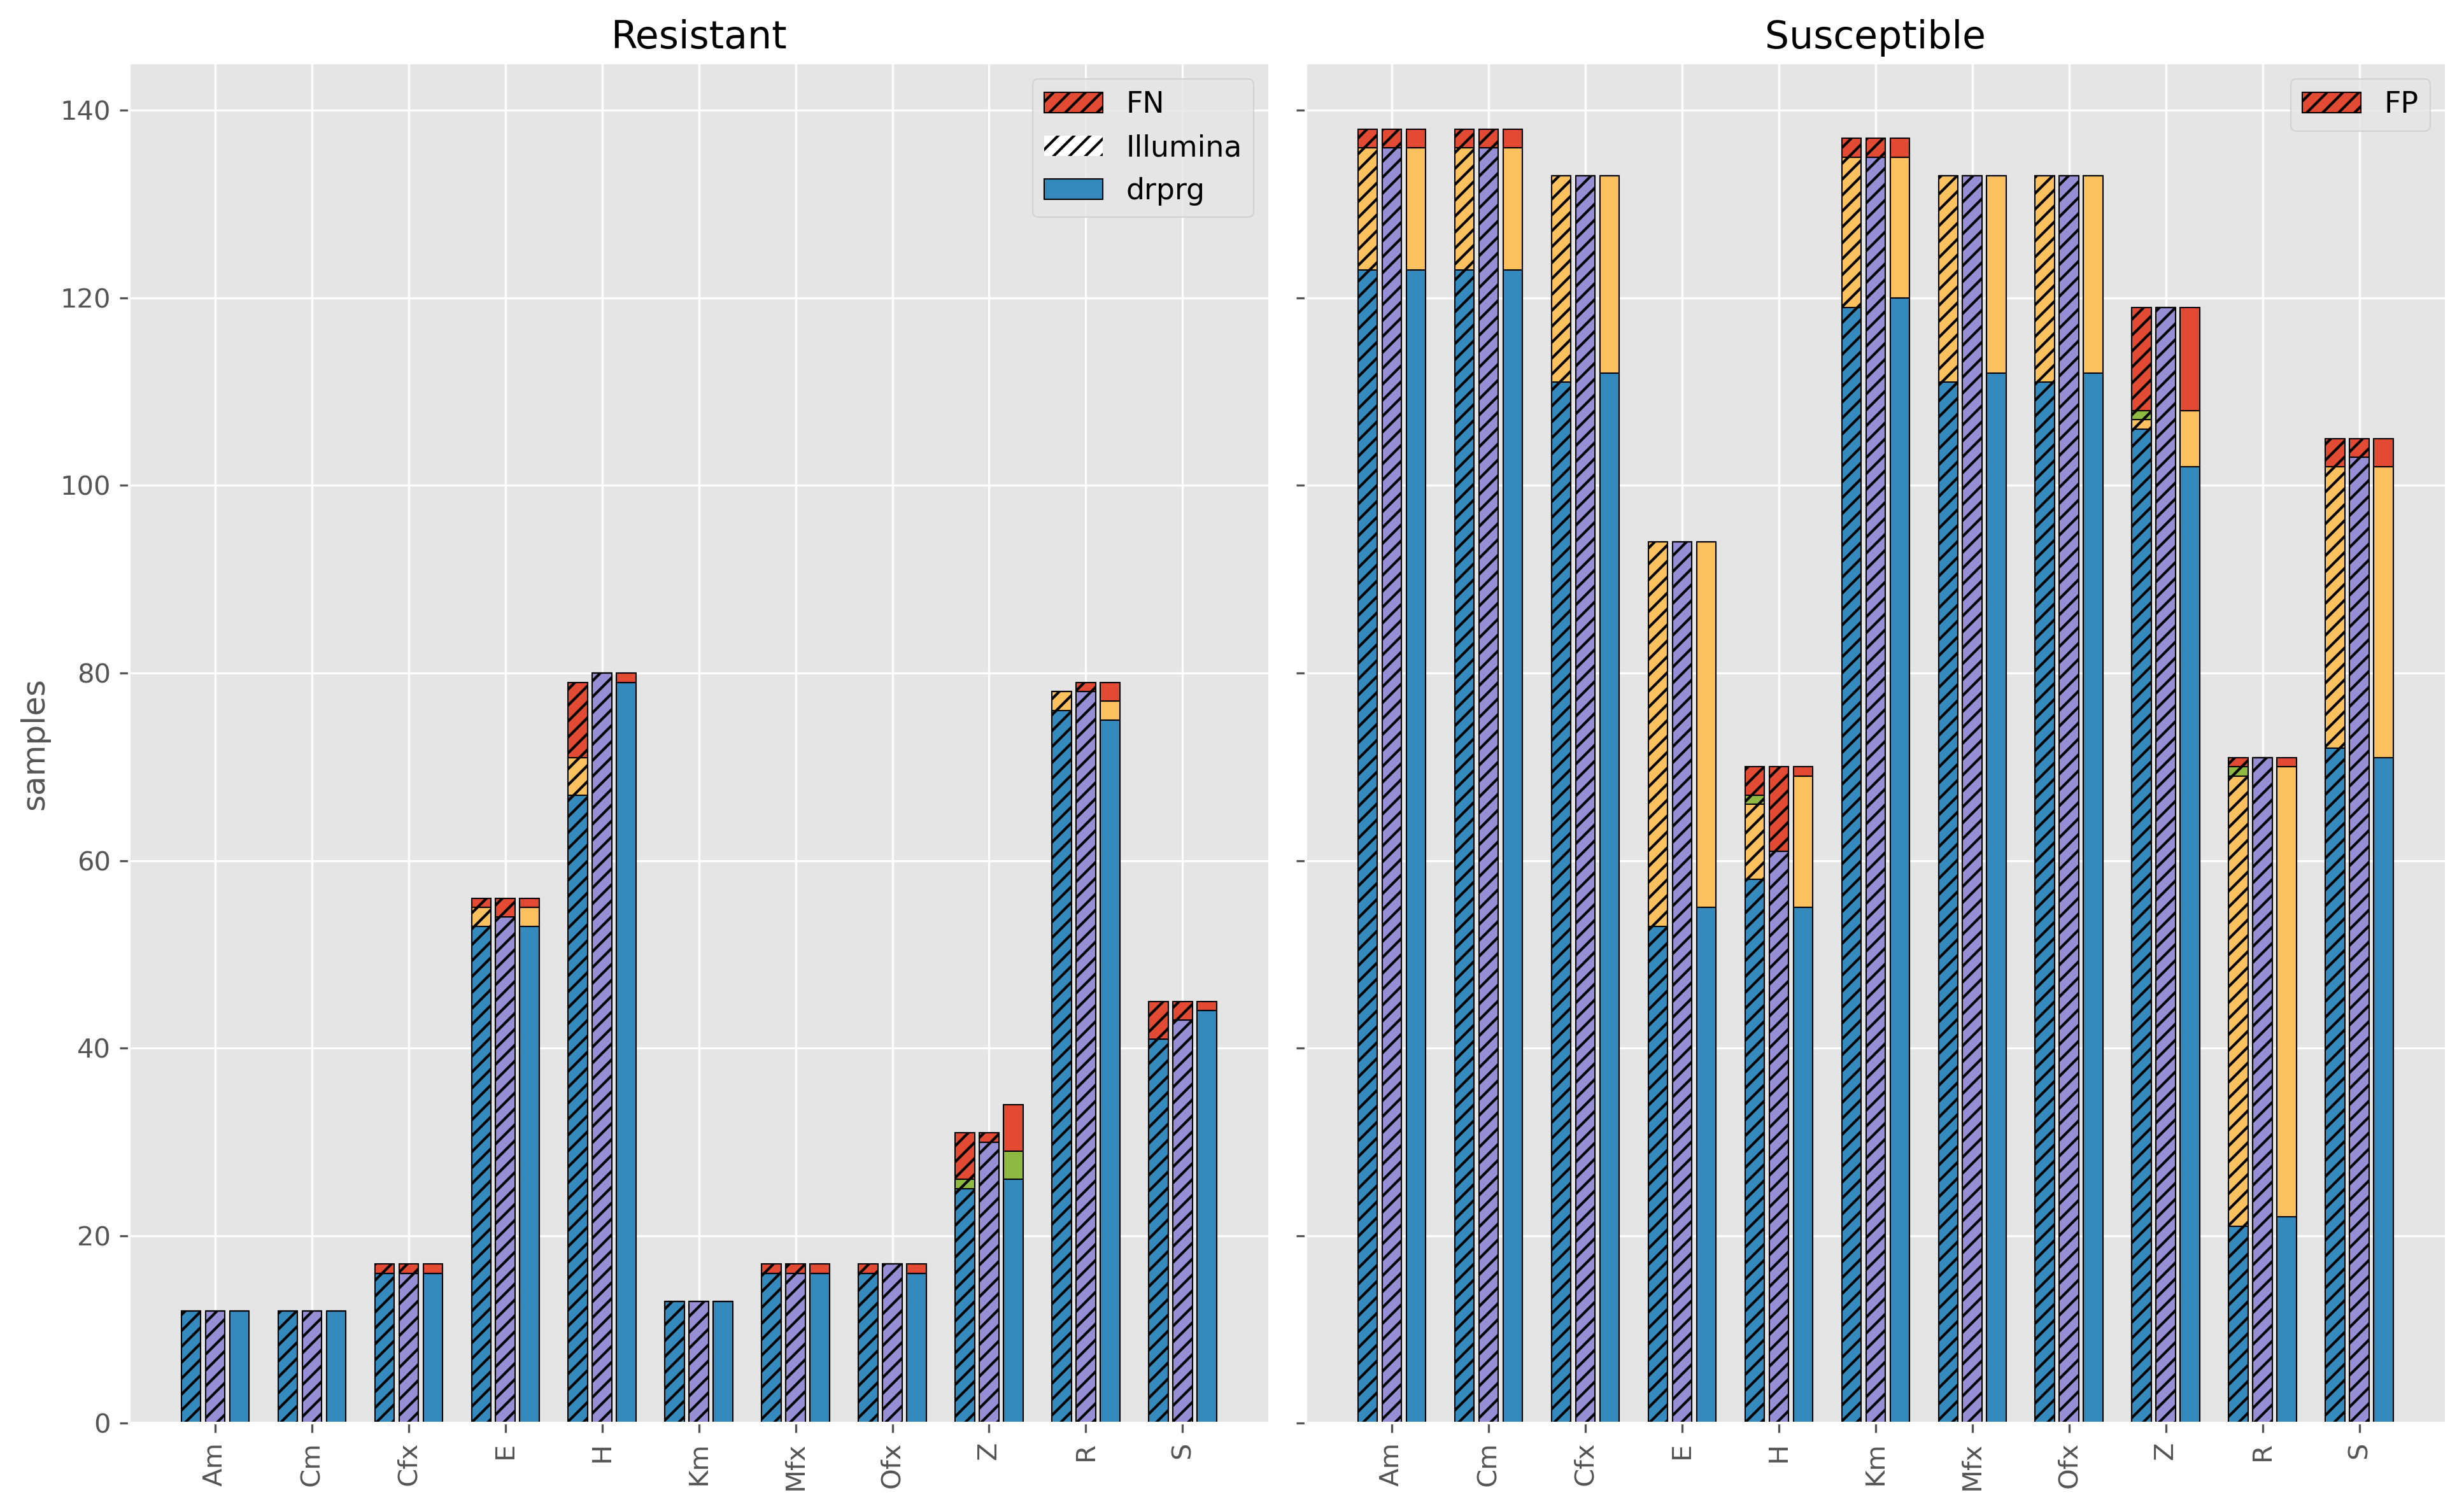

In [191]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 8), dpi=300, sharey=True)
axR = axes.flatten()[0]
axS = axes.flatten()[1]

# plot details
bar_width = 0.2
epsilon = 0.05
line_width = 0.5
alpha = 1.0
hatch = "////"

all_positions = []
for i, (tech, tool) in enumerate(product(TECHS, TOOLS)):
    if (tech, tool) == ("illumina", "mykrobe"):
        continue
    correct_novel = [
        calls.query("test_call == 'U' and classification == 'FN' and tech == @tech and tool == @tool and drug == @d").count()[0]
        for d in DRUGS
    ]
    correct_failed = [
        calls.query("test_call == 'F' and classification == 'FN' and tech == @tech and tool == @tool and drug == @d").count()[0]
        for d in DRUGS
    ]
    incorrect_novel = [
        calls.query("test_call == 'U' and classification == 'TN'  and tech == @tech and tool == @tool and drug == @d").count()[0]
        for d in DRUGS
    ]
    incorrect_failed = [
        calls.query("test_call == 'F' and classification == 'TN'  and tech == @tech and tool == @tool and drug == @d").count()[0]
        for d in DRUGS
    ]
    tns = [conf_mxs[(d, tech, tool)].tn - incorrect_novel[i] - incorrect_failed[i] for i, d in enumerate(DRUGS)]
    fns = [conf_mxs[(d, tech, tool)].fn - correct_novel[i] - incorrect_failed[i] for i, d in enumerate(DRUGS)]
    tps = [conf_mxs[(d, tech, tool)].tp for d in DRUGS]
    fps = [conf_mxs[(d, tech, tool)].fp for d in DRUGS]
    
    positions = [p + ((bar_width + epsilon) * i) for p in np.arange(len(tps))]
    all_positions.append(positions)
    
    colour = cmap[tool]

    # resistance bar plots
    tps_bar = axR.bar(
        positions,
        tps,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    u_tp_bar = axR.bar(
        positions,
        correct_novel,
        bar_width,
        bottom=tps,
        color=yellow,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    f_tp_bar = axR.bar(
        positions,
        correct_failed,
        bar_width,
        bottom=[x+y for x, y in zip(tps, correct_novel)],
        color=green,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fns_bar = axR.bar(
        positions,
        fns,
        bar_width,
        bottom=[x+y+z for x, y, z in zip(tps, correct_novel, correct_failed)],
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )


    # susceptible bar plots
    tns_bar = axS.bar(
        positions,
        tns,
        bar_width,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    u_fp_bar = axS.bar(
        positions,
        incorrect_novel,
        bar_width,
        bottom=tns,
        color=yellow,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    f_fp_bar = axS.bar(
        positions,
        incorrect_failed,
        bar_width,
        bottom=[x+y for x, y in zip(tns, incorrect_novel)],
        color=green,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    fps_bar = axS.bar(
        positions,
        fps,
        bar_width,
        bottom=[x+y+z for x, y, z in zip(tns, incorrect_novel, incorrect_failed)],
        color=red,
        edgecolor=edgecol,
        linewidth=line_width,
    )
    
    if tech == "nanopore":
        for bar in tps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fps_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in fns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in tns_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in u_fp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in u_tp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in f_fp_bar.patches:
            bar.set_hatch(hatch)
            
        for bar in f_tp_bar.patches:
            bar.set_hatch(hatch)
    else:
        tps_bar.set_label(tool)

    if i == 0:
        fps_bar.set_label("FP")
        fns_bar.set_label("FN")
        
labels = [drug_abbrev[d.lower()] for d in DRUGS]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=90)
axR.set_ylabel("samples")
axR.set_xticks(label_pos)
axR.set_xticklabels(axS.get_xticklabels(), rotation=90)
axR.set_title("Resistant")
axS.set_title("Susceptible")

axS.legend(loc="best", prop={"size": 11})
leghandles, leglabels = axR.get_legend_handles_labels()
from matplotlib.patches import Patch
hatch_leghandle = Patch(facecolor='white', hatch=hatch)
leghandles.insert(3, hatch_leghandle)
leglabels.insert(3, "Illumina")
leglabels.insert(3, leglabels.pop(1))
leghandles.insert(3, leghandles.pop(1))
axR.legend(leghandles, leglabels, loc="best", prop={"size": 11})

sns.despine()
plt.tight_layout()

In [217]:
fp_samples = set(novel_df.query("classification == 'FP'")["sample"])

In [186]:
[
        calls.query("test_call == 'U' and classification == 'TP' and tech == 'nanopore' and tool == 'drprg' and drug == @d").count()[0]
        for d in DRUGS
    ]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [189]:
set(calls.query("test_call == 'U'")["classification"])

{'FN', 'TN'}

In [223]:
xs = []
for sample in fp_samples:
    print(sample)
    sample_df = novel_df.query("sample == @sample and classification == 'FP'")
    fp_drugs = set(sample_df["drug"])
    print(f"FP to {fp_drugs}")
    xs.append(len(fp_drugs))

mada_1-53
FP to {'ethambutol', 'streptomycin'}
mada_130
FP to {'ofloxacin'}
mada_151
FP to {'rifampicin'}
mada_133
FP to {'rifampicin', 'isoniazid', 'streptomycin'}
mada_1-18
FP to {'ethambutol'}
mada_128
FP to {'streptomycin'}
mada_1-7
FP to {'streptomycin'}
mada_1-54
FP to {'ethambutol', 'streptomycin'}
mada_1-47
FP to {'capreomycin', 'streptomycin', 'amikacin', 'ofloxacin', 'kanamycin'}
mada_131
FP to {'ethambutol', 'rifampicin'}
mada_141
FP to {'rifampicin'}
mada_1-10
FP to {'kanamycin', 'capreomycin', 'amikacin'}
mada_1-8
FP to {'ethambutol'}
mada_122
FP to {'rifampicin', 'isoniazid', 'streptomycin'}
mada_1-39
FP to {'streptomycin'}
mada_1-44
FP to {'kanamycin', 'capreomycin', 'amikacin'}
mada_113
FP to {'streptomycin'}
R21363
FP to {'isoniazid'}
mada_111
FP to {'rifampicin', 'isoniazid'}
mada_1-41
FP to {'ethambutol', 'ofloxacin', 'streptomycin'}
mada_1-36
FP to {'ethambutol'}
mada_1-22
FP to {'kanamycin', 'capreomycin', 'amikacin'}
R28581
FP to {'isoniazid'}
R36431
FP to {'etham

In [227]:
df = pd.DataFrame(pheno_clf, columns=["sample", "drug", "classification", "tech", "covg", "tool", "site"])

In [228]:
d = defaultdict(list)
for i, row in df.query("classification == 'FP'").iterrows():
    d[row["drug"]].append((row["sample"], row["tool"], row["tech"]))

In [230]:
upset_data = upsetplot.from_contents(d)

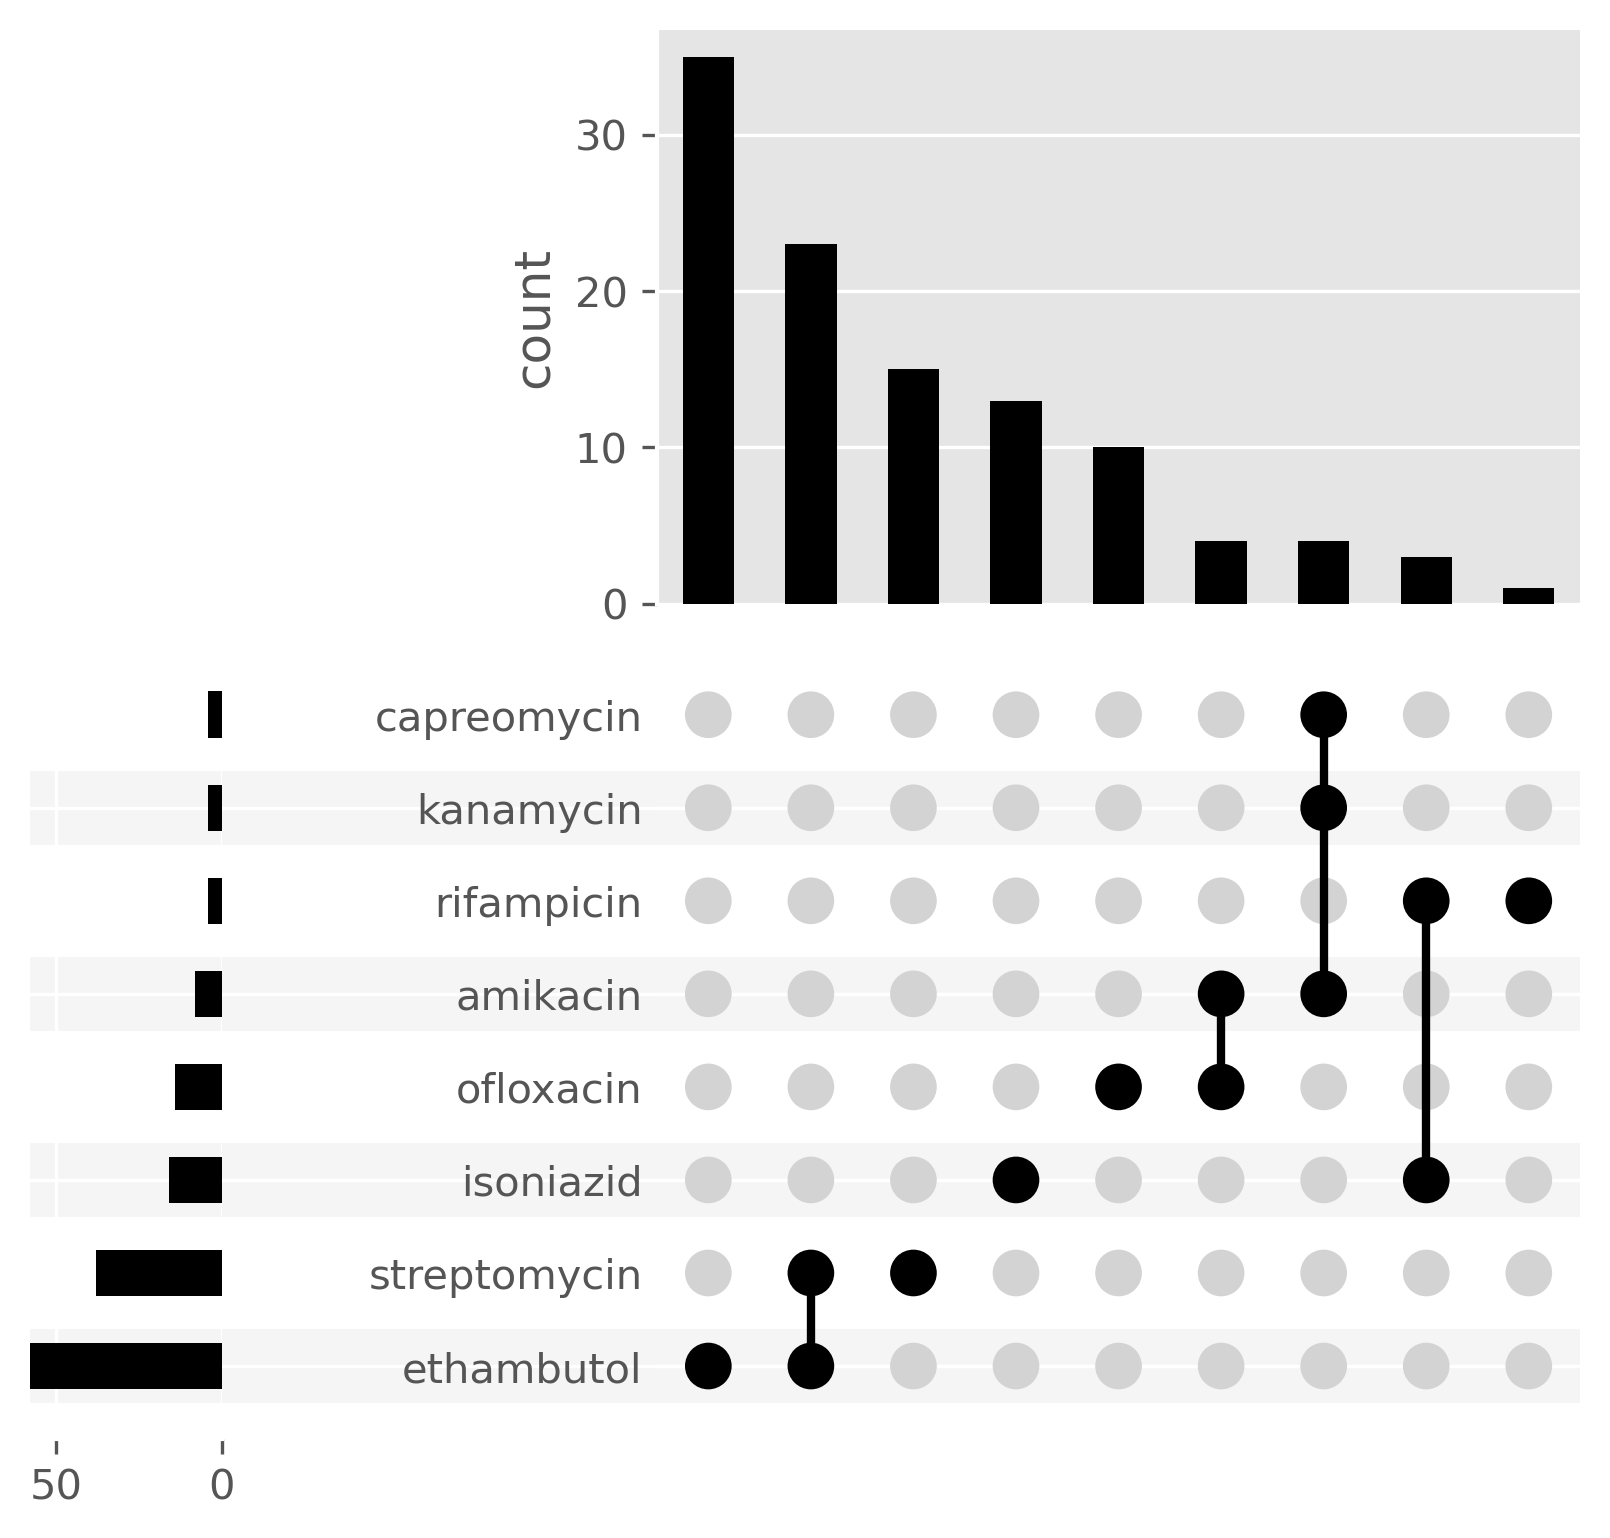

In [231]:
fig, ax = plt.subplots()
p = upsetplot.plot(
    upset_data,
    fig=fig,
    sort_by="cardinality",
    orientation="horizontal",
)
p["intersections"].set_ylabel("count")
ax.axis("off")
# fig.set_figwidth(8)
# fig.set_figheight(10)
fig.set_dpi(300)

Pull out the susceptible variants in the WHO panel and create a panel for them

In [42]:
p = "/Users/michaelhall/Downloads/catalogue.tsv"

In [43]:
# genes = set()
# with open("/Users/michaelhall/Downloads/panel.tsv") as f:
#     for row in f:
#         gene = row.split("\t")[0]
#         genes.add(gene)

In [44]:
# def is_indel(v):
#     return "ins" in v or "del" in v

# def which_residue(v):
#     if v[0].islower():
#         return "DNA"
#     else:
#         return "PROT"
    
# def convert_indel(v):
#     if not is_indel(v):
#         return v
#     fields = v.split("_")
#     pos = fields[0]
#     ref = fields[3]
#     alt = fields[4]
#     diff = int(fields[2])
#     delta_len = abs(len(ref)-len(alt))
#     if diff != delta_len:
#         raise ValueError(f"Allele length diff is {delta_len}: {v}")
#     return f"{ref}{pos}{alt}"

# def is_susceptible(grading):
#     return "Not assoc w R" in grading

In [45]:
# variants = set()
# with open(p) as f:
#     _ = next(f)
#     for row in map(str.rstrip, f):
#         _, variant, grading = row.split("\t")
#         if not is_susceptible(grading):
#             continue

#         gene, var = variant.split("_", maxsplit=1)
#         if gene not in genes:
#             continue
#         try:
#             var = convert_indel(var)
#         except ValueError:
#             print(f"Skipping {variant}")
#             continue
#         residue = which_residue(var)
#         if "(" in var:
#             var = var.split()[0]
#         variants.add((gene, var.upper(), residue, "NONE"))
        

In [46]:
# with open("/Users/michaelhall/Projects/head_to_head_pipeline/analysis/resistance_prediction/resources/non_resistant.tsv", "w") as fout:
#     for row in variants:
#         print("\t".join(row), file=fout)

In [47]:
# len(variants)

In [48]:
# for v in variants:
#     if v[0].startswith("gyrA"):
#         print(v)